# EEG Classification Notebook with Kalman Filter

Here we classify the EEG signal using a CNN. To generate the ground truth labels, we apply a kalman filter to the feeltrace signal, and then generate the emotion labels from this new signal.

In [1]:
# import some useful libraries

import os
import glob

import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import pandas as pd

from scipy import signal


# model creation
import torch.nn as nn
import torch.nn.functional as F
import torch

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.metrics import precision_recall_fscore_support
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import StratifiedKFold, KFold

# loading bar
from tqdm import tqdm

# kalman filter
from filterpy.common import Q_discrete_white_noise
from filterpy.kalman import KalmanFilter


/home/bkat/.local/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load Dataset

In [30]:
dir = '../eeg_feeltrace' # directory containing *.csv files
# hyper parameters
window_size = 500 # must be an int in milliseconds
subject_num = 5 # which subject to choose [1-16]
k_fold = 5 # k for k fold validation
apply_kf = True # apply kalman filter
label_type = 'accumulation' # 'angle' or 'pos' or 'both'
num_classes = 3 if label_type != 'both' else 9 # number of classes to discretize the labels into
num_features = 64 # eeg feature size
classifier_learning_rate = 1e-3 # adam learning rate
classifier_train_epochs = 10 # train classifier duration
classifier_hidden = 8 # classifier parameter, the larger the more complicated the model

In [23]:
# functions for preprocessing dataset
# The features are 5x64x64 images (Channel,Height,Width)

def load_dataset(dir = 'feeltrace', subject_num = 5):
    # choose the subject
    subject_data_files = glob.glob(os.path.join(dir, 'eeg_ft_*.csv'))
    # sort the files by the index given to them
    file_name_2_index = lambda file : int(file.split('.csv')[0].split('_')[-1])
    subject_data_files.sort() # sort alphabetically
    subject_data_files.sort(key=file_name_2_index) # sort by index
    eeg_ft = subject_data_files[subject_num-1]

    

    print(f"Chosen subject: {eeg_ft}")
    
    data_signal = pd.read_csv(eeg_ft) # read the Nx(1+1+64) data for a single subject
    scene_signal = pd.read_csv(eeg_ft.replace('eeg_ft_', 'scenes_', 1))

    # return signal
    return data_signal, scene_signal

def generate_label(eeg_ft, split_size=100, k=5, label_type='angle', num_classes=3, kf=False):

    # split into windows (non-overlapping)
    dataset = [eeg_ft[x : x + split_size] for x in range(0, len(eeg_ft), split_size)]
    if len(dataset[-1]) < split_size:
        dataset.pop() # remove last window if it is smaller than the rest

    if label_type != 'both':
        labels, raw_label = get_label(dataset, n_labels=num_classes, label_type=label_type, kf=kf, dt=split_size/1000) # (N, 1)
    else:
        labels, raw_label = get_combined_label(dataset, n_labels=int(np.sqrt(num_classes))) # (N, 1)

    dataset = generate_eeg_features(dataset)
    dataset = np.vstack([np.expand_dims(x,0) for x in dataset]) # (N, eeg_feature_size, 64)

    print(f"EEG feature shape (N, freq_bands, channels, channels):  {dataset.shape}")
    print(f"label set shape (N,):  {labels.shape}")

    indices = split_dataset(labels, k=k) # split data into train/test indices using kFold validation
    return dataset, labels, indices, raw_label


def apply_kalman(raw_label, dt=1e-3, R=1e2, var=1e2, p=1e2):
    kf = KalmanFilter(dim_x=2, dim_z=1)

    kf.x = np.array([[0.5],
                [0.]])       # initial state (location and angle)

    kf.F = np.array([[1.,dt],
                [0.,1.]])    # state transition matrix

    kf.H = np.array([[1.,1.]])    # Measurement function
    kf.P = np.array([[p,    0.],
                [   0., p] ])               # covariance matrix
    kf.R = R                      # state uncertainty
    kf.Q = Q_discrete_white_noise(dim=2, dt=dt, var=var) # process uncertainty

    kf_signal = np.zeros_like(raw_label)
    for i,m in enumerate(raw_label):
        kf.predict() # predict
        kf.update(m) # measure
        x = np.clip(kf.x[0], 0,1)
        kf_signal[i] = x
    return kf_signal


def generate_regression_label(eeg_ft, split_size=100, k=5, kf=False):
    # if kf:
    #     apply_kalman(eeg_ft, dt=split_size/1000)

    # split into windows (non-overlapping)
    dataset = [eeg_ft[x : x + split_size] for x in range(0, len(eeg_ft), split_size)]
    if len(dataset[-1]) < split_size:
        dataset.pop() # remove last window if it is smaller than the rest


    _, pos_raw_label = get_label(dataset, n_labels=3, label_type='pos') # (N, 1)
    _, angle_raw_label = get_label(dataset, n_labels=3, label_type='angle') # (N, 1)

    raw_label = np.hstack([pos_raw_label[:, None], angle_raw_label[:,None]])

    if kf:
        labels = apply_kalman_regression(raw_label, dt=split_size/1000)
    else:
        labels = raw_label


    dataset = generate_eeg_features(dataset)
    dataset = np.vstack([np.expand_dims(x,0) for x in dataset]) # (N, eeg_feature_size, 64)

    print(f"EEG feature shape (N, freq_bands, channels, channels):  {dataset.shape}")
    print(f"label set shape (N,):  {labels.shape}")

    indices = split_dataset(labels, k=k, strat=False) # split data into train/test indices using kFold validation
    return dataset, labels , indices, raw_label

def apply_kalman_regression(labels, dt=1e-3, R=1e2, var=1e2, p=1e2):
    kf = KalmanFilter(dim_x=2, dim_z=2)

    kf.x = np.array([[0.5],
                [0.]])       # initial state (location and angle)

    kf.F = np.array([[1.,dt],
                [0.,1.]])    # state transition matrix

    kf.H = np.array([[1.,0.],
    [0, 1]])    # Measurement function
    kf.P = np.array([[p,    0.],
                [   0., p] ])               # covariance matrix
    kf.R = R                      # state uncertainty
    kf.Q = Q_discrete_white_noise(dim=2, dt=dt, var=var) # process uncertainty

    kf_signal = np.zeros_like(labels)
    for i,m in enumerate(labels):
        kf.predict() # predict
        kf.update(m[:,None]) # measure
        kf_signal[i] = kf.x.squeeze()

    # re normalize to [0,1]
    kf_signal = (kf_signal - kf_signal.min(axis=0, keepdims=True)) / (kf_signal.max(axis=0, keepdims=True) - kf_signal.min(axis=0, keepdims=True))
    return kf_signal


def get_label(data, n_labels=3, label_type='angle', kf=False, dt=1e-3):
    if label_type == 'angle':
        labels = stress_2_angle(np.vstack([x[:,1].T for x in data])) # angle/slope mapped to [0,1] in a time window
    elif label_type == 'pos':
        labels = np.vstack([x[:,1].mean() for x in data]) # mean value within the time window
    else:
        labels = stress_2_accumulator(np.vstack([x[:,1].T for x in data])) # accumulator mapped to [0,1] in a time window

    if kf:
        labels = apply_kalman(labels, dt, R=1e3, var=1e3, p=1e3)
        
    label_dist = stress_2_label(labels, n_labels=n_labels).squeeze()
    return label_dist, labels.squeeze()

def get_combined_label(data, n_labels=3):
    angle_labels, _ = get_label(data, n_labels=n_labels, label_type='angle') # (N, 1)
    pos_labels, _ = get_label(data, n_labels=n_labels, label_type='pos') # (N, 1)

    labels = [x for x in range(n_labels)]
    labels_dict =  {(a, b) : n_labels*a+b for a in labels for b in labels} # cartesian product
    combined_labels = [labels_dict[(pos, angle)] for (pos, angle) in zip(pos_labels, angle_labels)]
    return np.array(combined_labels)


def stress_2_label(mean_stress, n_labels=5):
    # value is in [0,1] so map to [0,labels-1] and discretize
    return np.digitize(mean_stress * n_labels, np.arange(n_labels)) - 1

def stress_2_angle(stress_windows):
    '''
    do a linear least squares fit in the time window
    stress_window: (N_samples, time_window)
    '''
    xvals = np.arange(stress_windows.shape[-1])/1e3/60 # time in (minutes)
    slope = np.polyfit(xvals, stress_windows.T, 1)[0] # take slope linear term # 1/s
    angle = np.arctan(slope)/ (np.pi/2) * 0.5 + 0.5 # map to [0,1]
    return angle

def stress_2_accumulator(stress_windows):
    '''
    apply an integral to the time window
    stress_window: (N_samples, time_window)
    '''
    max_area = stress_windows.shape[-1]
    xvals = np.arange(stress_windows.shape[-1]) # time in (ms)
    integral = np.trapz(stress_windows, x=xvals)
    return integral/max_area # map to [0,1]

def split_dataset(labels, k=5, strat=True):
    '''
    split the features and labels into k groups for k fold validation
    we use StratifiedKFold to ensure that the class distributions within each sample is the same as the global distribution
    '''
    if strat:
        kf = StratifiedKFold(n_splits=k, shuffle=True)
    else:
        kf = KFold(n_splits=k, shuffle=True)

    # only labels are required for generating the split indices so we ignore it
    temp_features = np.zeros_like(labels)
    indices = [(train_index, test_index) for train_index, test_index in kf.split(temp_features, labels)]
    return indices

def generate_eeg_features(dataset):
    sample_freq = 1000
    # get FFT
    psd_windows = [signal.periodogram(x[:,2:], sample_freq, axis=0) for x in dataset ] # get the power spectral density for each window

    # frequency bands
    bands={'alpha': (8, 12), 'beta': (12, 30), 'delta': (1, 4), 'theta': (4, 7), 'gamma': (30, 50)}
    band_freqs = [bands[x] for x in ['alpha', 'beta', 'delta', 'theta', 'gamma']]

    features = []
    for window in psd_windows: # calculate the power in each band for channel for each window
        freqs, psd = window
        idx_bands = [np.logical_and(freqs >= low, freqs <= high) for low,high in band_freqs]

        freq_res = freqs[1] - freqs[0]
        band_powers = np.array([sp.integrate.simpson(psd[idx,:], dx=freq_res, axis=0) for idx in idx_bands]) # (5,64)
        total_powers = np.array([sp.integrate.simpson(psd, dx=freq_res, axis=0) for idx in idx_bands]) # (5,64)
        diff_entropy = -0.5 * np.log(band_powers/total_powers)
        # (5, 1, 64)
        # (5, 64, 1)
        diff_de = np.expand_dims(diff_entropy, axis=2) - np.expand_dims(diff_entropy, axis=1) # (5,64,64)
        diff_de = (diff_de  - diff_de.min(axis=(1,2), keepdims=True))/(diff_de.max(axis=(1,2), keepdims=True) - diff_de.min(axis=(1,2), keepdims=True))
        
        features.append(diff_de)
    return features

In [4]:
eeg_ft_signal, scenes_df = load_dataset(dir = dir, subject_num = subject_num)

Chosen subject: ../eeg_feeltrace/eeg_ft_4.csv


In [5]:
print(scenes_df.info())

print(eeg_ft_signal.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37 entries, 0 to 36
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   t       37 non-null     float64
 1   scene   37 non-null     object 
dtypes: float64(1), object(1)
memory usage: 720.0+ bytes
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517619 entries, 0 to 517618
Data columns (total 66 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   t           517619 non-null  float64
 1   stress      517619 non-null  float64
 2   channel_0   517619 non-null  float64
 3   channel_1   517619 non-null  float64
 4   channel_2   517619 non-null  float64
 5   channel_3   517619 non-null  float64
 6   channel_4   517619 non-null  float64
 7   channel_5   517619 non-null  float64
 8   channel_6   517619 non-null  float64
 9   channel_7   517619 non-null  float64
 10  channel_8   517619 non-null  float64
 11  channel_9   517619 non-nul

In [6]:
scenes_df

,t,scene
0,45.600,Light-truck-1
1,62.533,Truck-backup
2,69.967,Truck-tree
3,81.200,Portal-light
4,87.100,Flashlight-portal
5,107.333,Portal-tree
6,110.700,Inframe
7,126.233,Fridge-hit
8,131.800,Fridge-wall
9,132.933,Truck-move


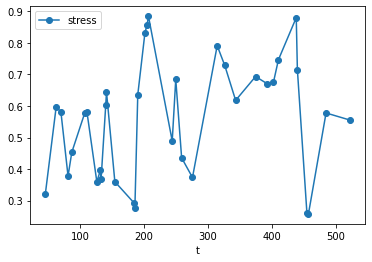

In [7]:
eeg_ft_signal[eeg_ft_signal['t'].isin(scenes_df['t'])][['t','stress']].plot(x='t', y='stress', marker='o')
plt.show()

EEG feature shape (N, freq_bands, channels, channels):  (1035, 5, 64, 64)
label set shape (N,):  (1035,)
EEG feature shape (N, freq_bands, channels, channels):  (1035, 5, 64, 64)
label set shape (N,):  (1035,)
Label class bincount: [108 662 265]


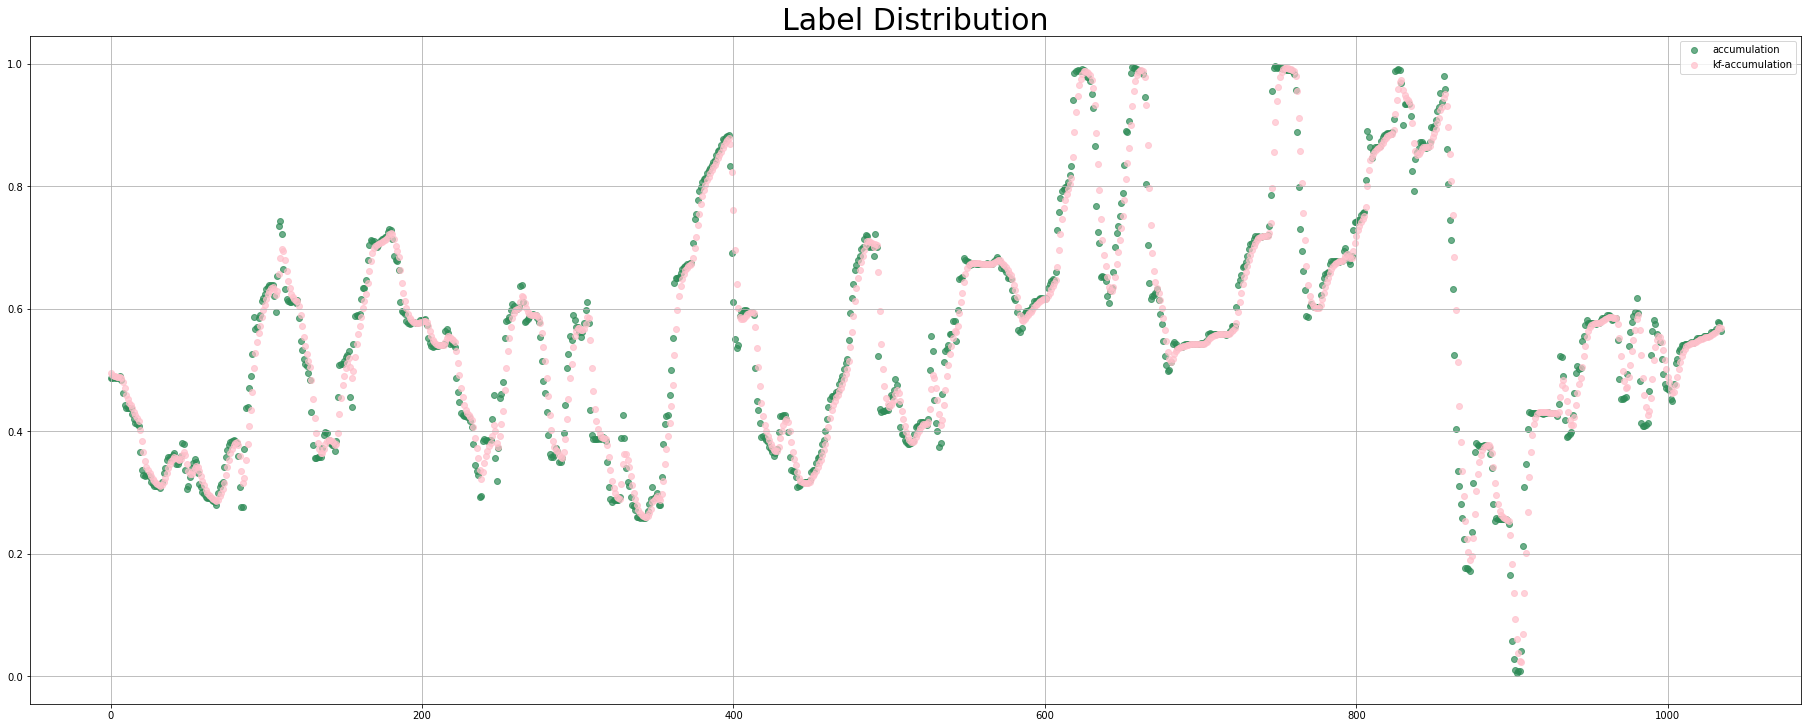

In [31]:
eeg_features, labels, indices, kf_raw_label = generate_label(eeg_ft_signal.values, split_size=window_size, k=k_fold, label_type=label_type, num_classes=num_classes, kf=apply_kf)
_, _, _, raw_label = generate_label(eeg_ft_signal.values, split_size=window_size, k=k_fold, label_type=label_type, num_classes=num_classes, kf=False)
print(f"Label class bincount: {np.bincount(labels, minlength=num_classes)}")


fsize = 30

fig, axes = plt.subplots(figsize=(25,10), nrows=1, ncols=1, sharey='row', sharex='row', gridspec_kw = {'wspace':0.01, 'hspace':0}, constrained_layout=True )
axes.scatter(np.arange(len(labels)), raw_label, alpha=0.7, color='seagreen', label=label_type)
axes.scatter(np.arange(len(labels)), kf_raw_label, alpha=0.7, color='pink', label='kf-'+label_type )
axes.grid('on', linestyle='-')
axes.set_aspect('auto')
axes.set_title('Label Distribution', fontsize=fsize)
axes.legend(loc='best')
plt.show()

In [83]:
# eeg_features, labels, indices, raw_label = generate_regression_label(eeg_ft_signal.values, split_size=window_size, k=k_fold, kf=apply_kf)
# #print(f"Label class bincount: {np.bincount(labels, minlength=num_classes)}")


# fsize = 30

# fig, axes = plt.subplots(figsize=(25,10), nrows=1, ncols=1, sharey='row', sharex='row', gridspec_kw = {'wspace':0.01, 'hspace':0}, constrained_layout=True )
# axes.scatter(np.arange(len(labels)), raw_label[:,0], alpha=0.7, color='seagreen', label='position')
# axes.scatter(np.arange(len(labels)), labels[:,0], alpha=0.7, color='slateblue', label='kf-position')
# axes.grid('on', linestyle='-')
# axes.set_aspect('auto')
# axes.set_title('Label Distribution', fontsize=fsize)
# axes.legend(loc='best')
# plt.show()

# fig, axes = plt.subplots(figsize=(25,10), nrows=1, ncols=1, sharey='row', sharex='row', gridspec_kw = {'wspace':0.01, 'hspace':0}, constrained_layout=True )
# axes.scatter(np.arange(len(labels)), raw_label[:,1], alpha=0.7, color='pink', label='angle')
# axes.scatter(np.arange(len(labels)), labels[:,1], alpha=0.7, color='gray', label='kf-angle')
# axes.grid('on', linestyle='-')
# axes.set_aspect('auto')
# axes.set_title('Label Distribution', fontsize=fsize)
# axes.legend(loc='best')
# plt.show()



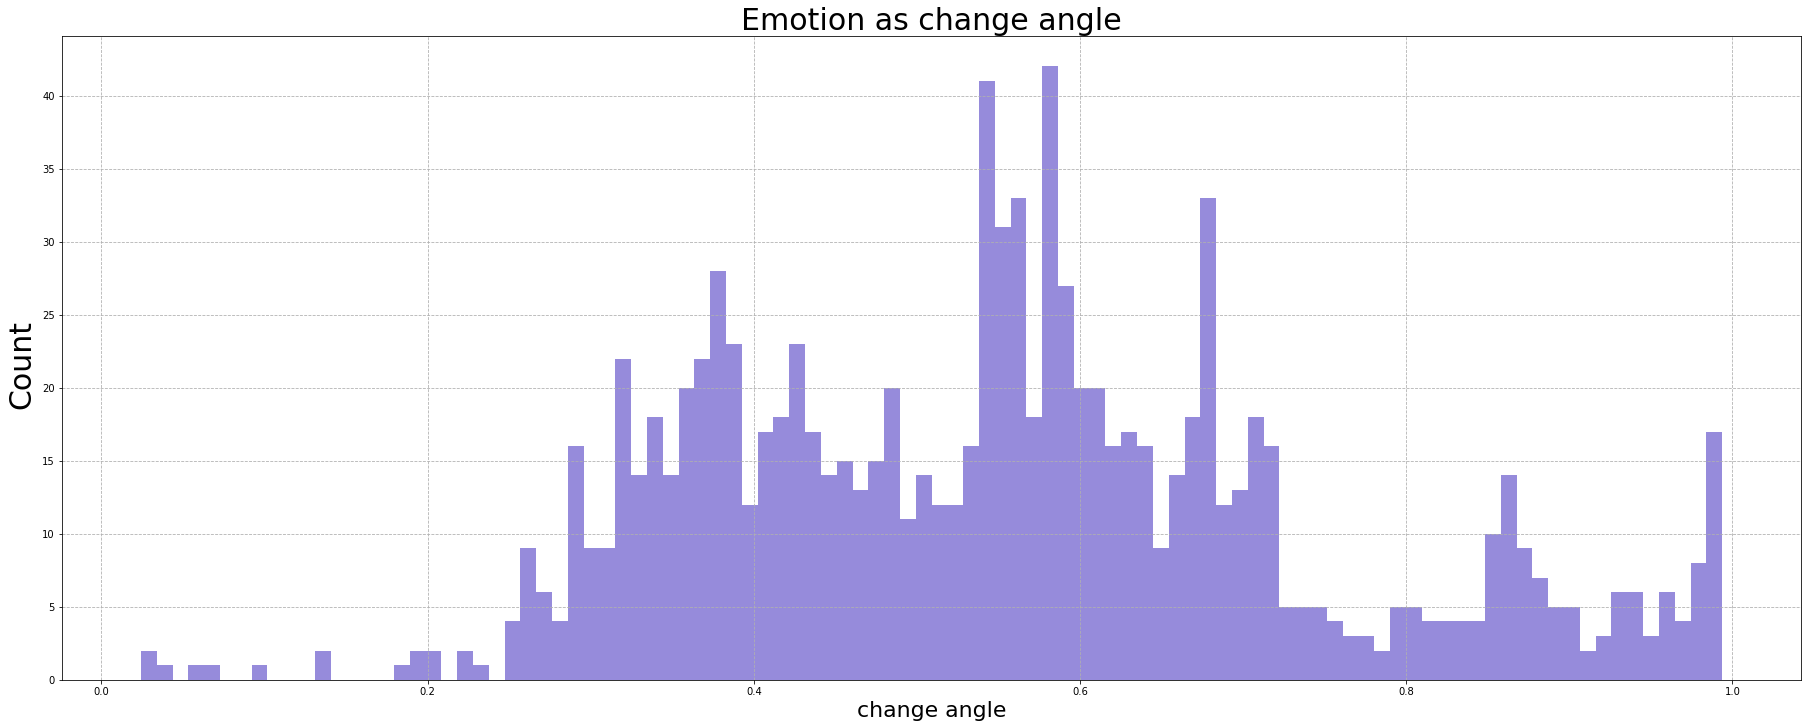

In [32]:
fig, axes = plt.subplots(figsize=(25,10), nrows=1, ncols=1, sharey='row', sharex='row', gridspec_kw = {'wspace':0.01, 'hspace':0}, constrained_layout=True )
n_bins = 100
fsize = 30
lsize = 22

axes.hist(kf_raw_label, histtype='stepfilled', alpha=0.7, bins=n_bins, color='slateblue', label='position')
axes.grid('on', linestyle='--')
axes.set_aspect('auto')
axes.set_title('Emotion as change angle', fontsize=fsize)
axes.set_xlabel('change angle', fontsize=lsize)


fig.supylabel('Count', fontsize=fsize)
plt.show()


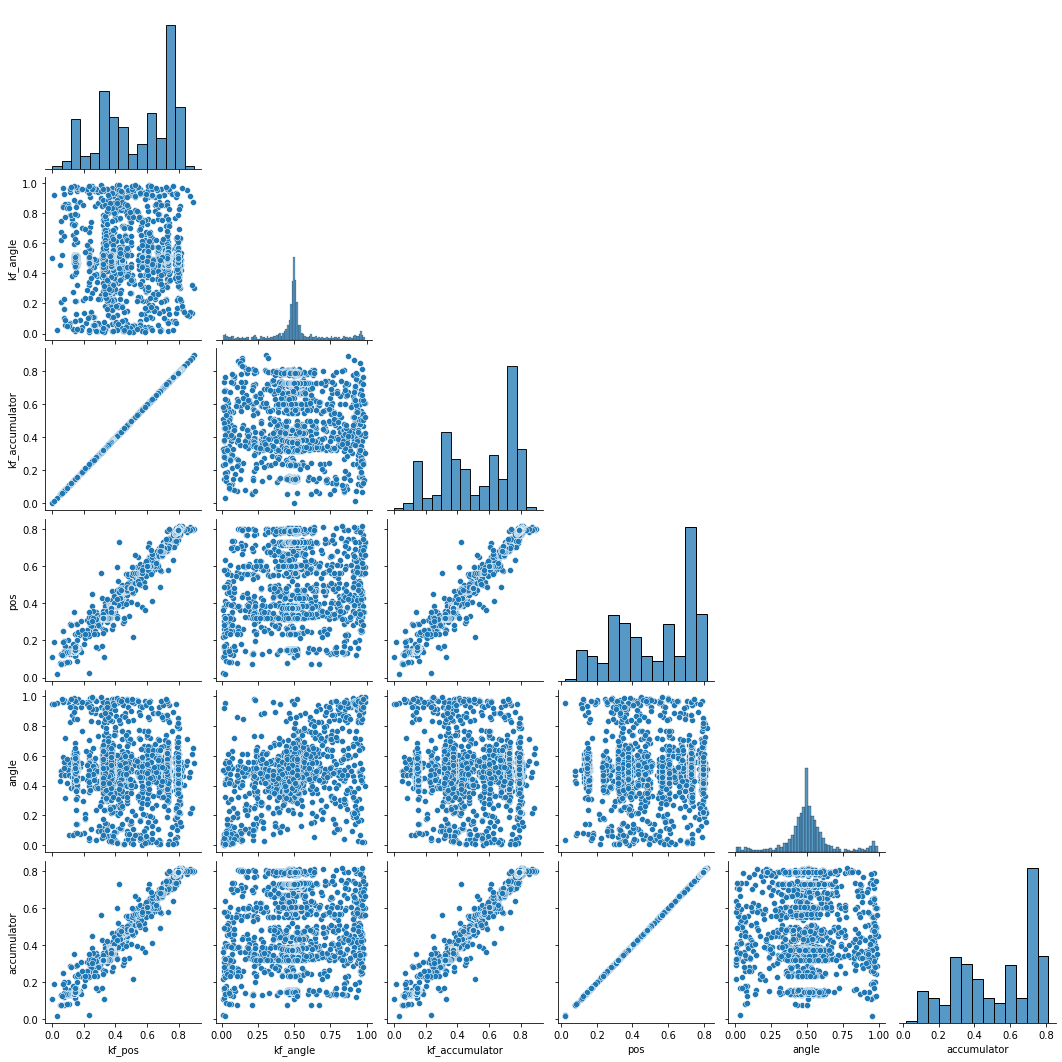

In [26]:
import seaborn as sns
g = sns.pairplot(data=label_df[["kf_pos", "kf_angle", "kf_accumulator", "pos", "angle", "accumulator"]], corner=True)
plt.show()
del g

## EEG Classifier and Training Function

In [13]:
class classifier(nn.Module):
    def __init__(self, num_features=12, num_hidden=32, dropout=0.2, n_labels=5):
        super(classifier, self).__init__()
        
        self.hidden_size = num_hidden
        self.input_size = num_features
        self.n_classes = n_labels


        self.cnn = nn.Sequential(
            nn.Conv2d(5, 8, 3, padding='same'),
            nn.ReLU()
        )
        
        self.classify = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(p=dropout),
            nn.Linear(64 * 64 * 8, self.n_classes))
    
    def forward(self,x):
        x = self.cnn(x)
        x = self.classify(x) 
        return x

class regressor(nn.Module):
    def __init__(self, num_features=12, num_hidden=32, dropout=0.2, n_labels=2):
        super(regressor, self).__init__()
        
        self.hidden_size = num_hidden
        self.input_size = num_features
        self.n_classes = n_labels


        self.cnn = nn.Sequential(
            nn.Conv2d(5, 8, 3, padding='same'),
            nn.ReLU()
        )
        
        self.classify = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(p=dropout),
            nn.Linear(64 * 64 * 8, self.n_classes),
            nn.Sigmoid())
    
    def forward(self,x):
        x = self.cnn(x)
        x = self.classify(x) 
        return x

class classifier_dataset(torch.utils.data.Dataset):
    def __init__(self, features, labels):
        'Initialization'
        self.x = features # (N, eeg_feature_size, 64)
        self.labels = labels # (N, 1)

    def __len__(self):
        'Denotes the total number of samples'
        return len(self.x)

    def __getitem__(self, index):
        'Generates one sample of data'
        # Select sample
        x = torch.from_numpy(self.x[index]).float() # (eeg_feature_size, 64, 64)
        y = torch.from_numpy(np.array(self.labels[index])).long() # feel trace labels int value [0,n_labels]
        return x, y


def train_classifier(model, num_epochs=5, batch_size=1, learning_rate=1e-3, features=None, labels=None,  label_smoothing=0.0):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)

    criterion = nn.CrossEntropyLoss(label_smoothing=label_smoothing)
    train_dataset = classifier_dataset(features, labels)
    
    # figure out class distribution to over sample less represented classes

    train_labels = labels
    
    # get the weights of each class as 1/occurrence
    train_class_weight = np.bincount(train_labels, minlength=num_classes)
    print(f"Train label distribution: {train_class_weight}")
    train_class_weight = 1/train_class_weight
    
    # get the per sample weight, which is the likelihood os sampling
    train_sample_weights = [train_class_weight[x] for x in train_labels]
    
    # sampler, weighted by the inverse of the occurrence
    train_sampler = torch.utils.data.WeightedRandomSampler(train_sample_weights, len(train_sample_weights), replacement=True)
    
        
    train_loader = torch.utils.data.DataLoader(train_dataset, 
                                               batch_size=batch_size,
                                               num_workers=8,
                                               sampler=train_sampler)
    
    train_metrics = []
    for epoch in range(num_epochs):
        
        # reset metrics
        cur_train_acc = 0 # accuracy
        cur_train_pc = 0 # precision
        cur_train_rc = 0 # recall
        cur_train_f1 = 0 # f1
        cur_train_loss = 0 # loss
        
        # set to train mode
        model.train()
        
        # loop over dataset
        for data in tqdm(train_loader):
            x, y = data
            x = x.to(device)
            y = y.to(device)
            
            y_hat = model(x)
            loss = criterion(y_hat, y)
            
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
            y_hat_np = F.softmax(y_hat.detach(), dim=1).argmax(axis=1).cpu().numpy().squeeze().reshape(-1,) # predictions
            y_np = y.detach().cpu().numpy().squeeze().reshape(-1,) # labels
            
            # metrics
            prf = precision_recall_fscore_support(y_np, y_hat_np, average='macro', zero_division=0)
            
            cur_train_acc += np.mean(y_hat_np == y_np)
            cur_train_pc += prf[0]
            cur_train_rc += prf[1]
            cur_train_f1 += prf[2]
            cur_train_loss += loss.detach().cpu()
        
        # average metrics over loop
        train_loop_size = len(train_loader)
        cur_train_acc  = cur_train_acc/train_loop_size
        cur_train_pc   = cur_train_pc/train_loop_size
        cur_train_rc   = cur_train_rc/train_loop_size
        cur_train_f1   = cur_train_f1/train_loop_size
        cur_train_loss = cur_train_loss/train_loop_size
        
        
        train_metrics.append([cur_train_acc, cur_train_pc, cur_train_rc, cur_train_f1, cur_train_loss])
            
        print(f'Epoch:{epoch+1},'\
              f'\nTrain Loss:{cur_train_loss},'\
              f'\nTrain Accuracy:{cur_train_acc},'\
              f'\nTrain Recall: {cur_train_rc},'\
              f'\nTrain precision: {cur_train_pc},' \
              f'\nTrain F1-Score:{cur_train_f1},')
        
    return train_metrics


def train_regressor(model, num_epochs=5, batch_size=1, learning_rate=1e-3, features=None, labels=None):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)

    criterion = nn.MSELoss()
    train_dataset = classifier_dataset(features, labels)
    
    # figure out class distribution to over sample less represented classes

    train_loader = torch.utils.data.DataLoader(train_dataset, 
                                               batch_size=batch_size,
                                               num_workers=8)
    
    train_metrics = []
    for epoch in range(num_epochs):
        
        # reset metrics
        cur_train_loss = 0 # loss
        
        # set to train mode
        model.train()
        
        # loop over dataset
        for data in tqdm(train_loader):
            x, y = data
            x = x.to(device)
            y = y.to(device)
            
            y_hat = model(x)
            loss = criterion(y_hat, y)
            
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
            
            # metrics
            cur_train_loss += loss.detach().cpu()
        
        # average metrics over loop
        train_loop_size = len(train_loader)
        cur_train_loss = cur_train_loss/train_loop_size
        
        
        train_metrics.append([cur_train_loss])
            
        print(f'Epoch:{epoch+1},'\
              f'\nTrain Loss:{cur_train_loss}')
        
    return train_metrics

## Training Classifier Loop

Training k=0
Training Classifier!
Train label distribution: [ 87 529 212]


100%|██████████| 7/7 [00:01<00:00,  4.42it/s]


Epoch:1,
Train Loss:2.492616891860962,
Train Accuracy:0.33444940476190477,
Train Recall: 0.34765724471606824,
Train precision: 0.17302619772577096,
Train F1-Score:0.1991743085651326,


100%|██████████| 7/7 [00:01<00:00,  4.98it/s]


Epoch:2,
Train Loss:1.570919156074524,
Train Accuracy:0.33697916666666666,
Train Recall: 0.3319207709451612,
Train precision: 0.1717976236193402,
Train F1-Score:0.17181138366435164,


100%|██████████| 7/7 [00:01<00:00,  5.11it/s]


Epoch:3,
Train Loss:1.366868257522583,
Train Accuracy:0.3306547619047619,
Train Recall: 0.341426812270802,
Train precision: 0.16737115198476035,
Train F1-Score:0.19359418325352515,


100%|██████████| 7/7 [00:01<00:00,  4.83it/s]


Epoch:4,
Train Loss:1.1158431768417358,
Train Accuracy:0.3444940476190476,
Train Recall: 0.3380965358241959,
Train precision: 0.27318988247135795,
Train F1-Score:0.19908541124848173,


100%|██████████| 7/7 [00:01<00:00,  4.90it/s]


Epoch:5,
Train Loss:1.1213340759277344,
Train Accuracy:0.32075892857142857,
Train Recall: 0.33438843116262473,
Train precision: 0.17778839067530353,
Train F1-Score:0.16729963726924377,


100%|██████████| 7/7 [00:01<00:00,  5.09it/s]


Epoch:6,
Train Loss:1.0965970754623413,
Train Accuracy:0.34635416666666663,
Train Recall: 0.3575199622291646,
Train precision: 0.3273057235323265,
Train F1-Score:0.2736340717823626,


100%|██████████| 7/7 [00:01<00:00,  4.86it/s]


Epoch:7,
Train Loss:1.0833332538604736,
Train Accuracy:0.42827380952380956,
Train Recall: 0.40353727432690556,
Train precision: 0.5372058025999117,
Train F1-Score:0.33502450920177906,


100%|██████████| 7/7 [00:01<00:00,  4.60it/s]


Epoch:8,
Train Loss:1.0855505466461182,
Train Accuracy:0.4162202380952381,
Train Recall: 0.3870625802840073,
Train precision: 0.358789690676815,
Train F1-Score:0.299564696189046,


100%|██████████| 7/7 [00:01<00:00,  5.03it/s]


Epoch:9,
Train Loss:1.081899642944336,
Train Accuracy:0.4156994047619048,
Train Recall: 0.42186030407635977,
Train precision: 0.4410629093114013,
Train F1-Score:0.3584318800348204,


100%|██████████| 7/7 [00:01<00:00,  4.79it/s]


Epoch:10,
Train Loss:1.0695302486419678,
Train Accuracy:0.4568452380952381,
Train Recall: 0.454777120548377,
Train precision: 0.45709681783136114,
Train F1-Score:0.3807174524386255,
Test label distribution: [ 21 133  53]
Precision: 0.3774234017511866
Recall: 0.42578143471887264
F1-Score: 0.26735055895475685
Base line F1-Score: 0.2607843137254902
Accuracy: 0.2898550724637681
Metrics:
              precision    recall  f1-score   support

           0       0.13      0.43      0.20        21
           1       0.67      0.08      0.14       133
           2       0.34      0.77      0.47        53

    accuracy                           0.29       207
   macro avg       0.38      0.43      0.27       207
weighted avg       0.53      0.29      0.23       207



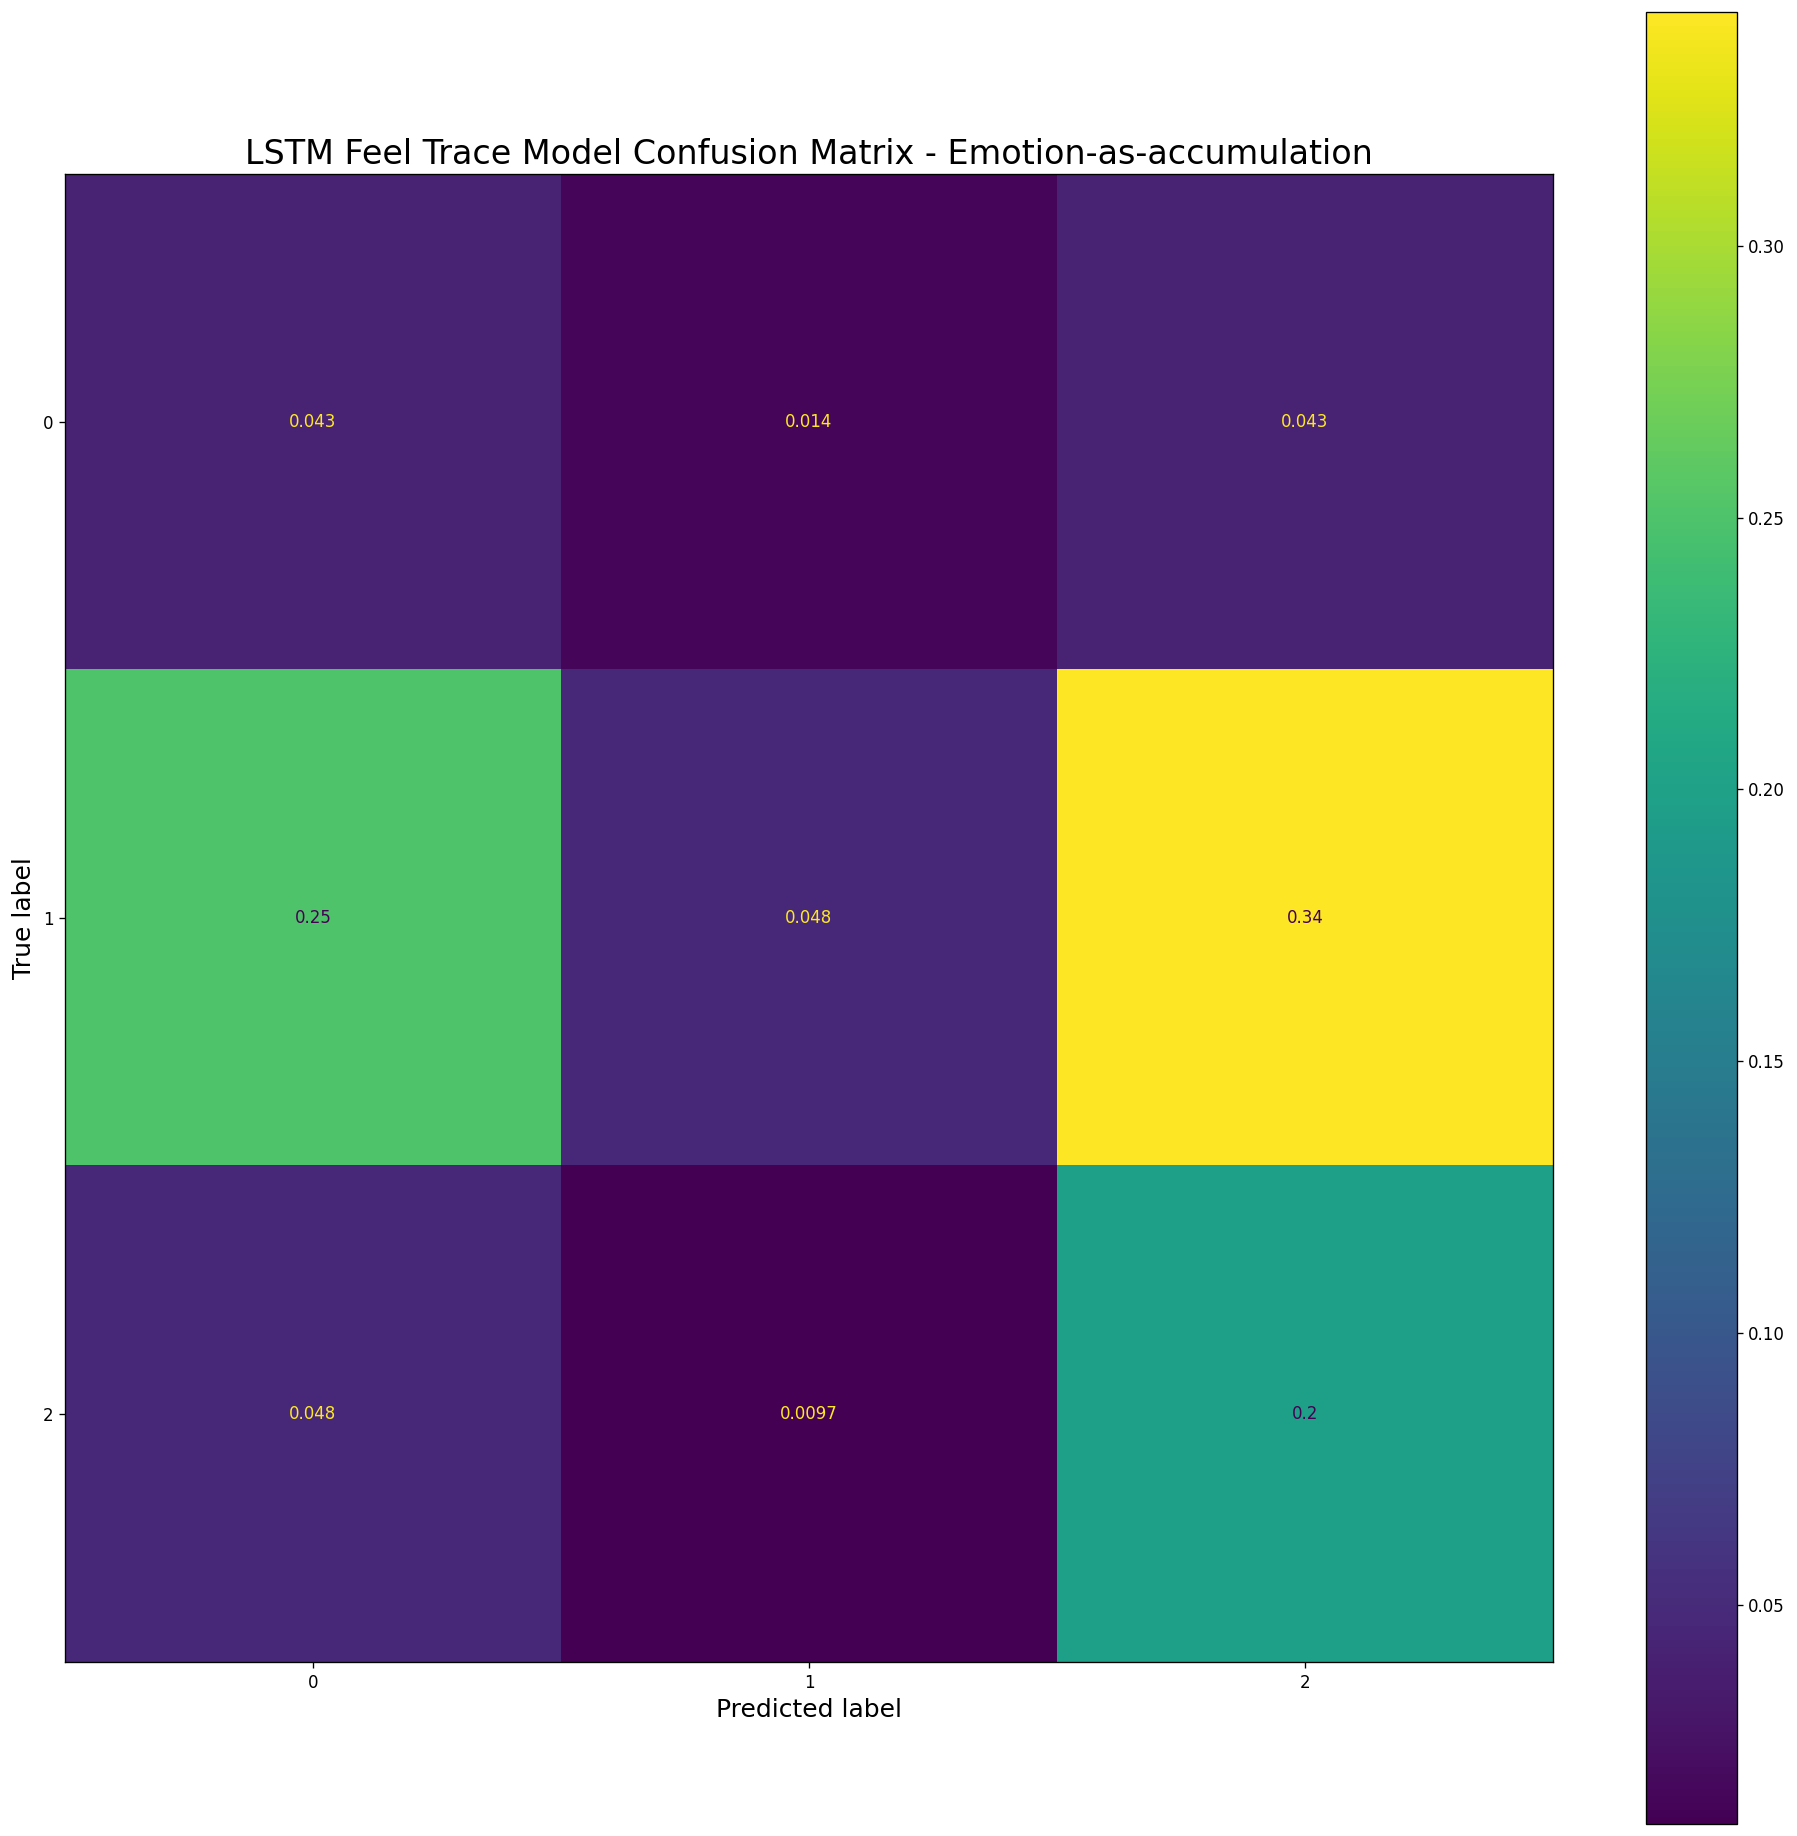

Training k=1
Training Classifier!
Train label distribution: [ 87 529 212]


100%|██████████| 7/7 [00:01<00:00,  4.70it/s]


Epoch:1,
Train Loss:1.4708783626556396,
Train Accuracy:0.34799107142857144,
Train Recall: 0.3409198461993493,
Train precision: 0.16388063703114725,
Train F1-Score:0.1999706885516077,


100%|██████████| 7/7 [00:01<00:00,  4.56it/s]


Epoch:2,
Train Loss:1.1920007467269897,
Train Accuracy:0.32172619047619044,
Train Recall: 0.3477939366665124,
Train precision: 0.24149129111537654,
Train F1-Score:0.20063030771772492,


100%|██████████| 7/7 [00:01<00:00,  4.69it/s]


Epoch:3,
Train Loss:1.0833052396774292,
Train Accuracy:0.3943452380952381,
Train Recall: 0.40162500223990855,
Train precision: 0.4420806436347962,
Train F1-Score:0.33883395451122567,


100%|██████████| 7/7 [00:01<00:00,  4.84it/s]


Epoch:4,
Train Loss:1.0743662118911743,
Train Accuracy:0.39784226190476196,
Train Recall: 0.38981183854544527,
Train precision: 0.40283271650105706,
Train F1-Score:0.3211865742213809,


100%|██████████| 7/7 [00:01<00:00,  4.64it/s]


Epoch:5,
Train Loss:1.056530237197876,
Train Accuracy:0.4191220238095238,
Train Recall: 0.40293416370463914,
Train precision: 0.49817308977762015,
Train F1-Score:0.35375407222670574,


100%|██████████| 7/7 [00:01<00:00,  4.70it/s]


Epoch:6,
Train Loss:1.053219199180603,
Train Accuracy:0.41793154761904766,
Train Recall: 0.4075906032058332,
Train precision: 0.4372827034612529,
Train F1-Score:0.3876259078014558,


100%|██████████| 7/7 [00:01<00:00,  4.71it/s]


Epoch:7,
Train Loss:1.0210984945297241,
Train Accuracy:0.4991815476190476,
Train Recall: 0.5082318071172388,
Train precision: 0.5146556880042285,
Train F1-Score:0.49280863866796537,


100%|██████████| 7/7 [00:01<00:00,  4.68it/s]


Epoch:8,
Train Loss:1.01926589012146,
Train Accuracy:0.4840029761904762,
Train Recall: 0.4880682583880279,
Train precision: 0.4789706823846827,
Train F1-Score:0.4776222196340912,


100%|██████████| 7/7 [00:01<00:00,  4.71it/s]


Epoch:9,
Train Loss:0.9858116507530212,
Train Accuracy:0.5342261904761905,
Train Recall: 0.5364412397871988,
Train precision: 0.5388991382677443,
Train F1-Score:0.534013171534888,


100%|██████████| 7/7 [00:01<00:00,  4.71it/s]


Epoch:10,
Train Loss:0.9958673715591431,
Train Accuracy:0.5298363095238096,
Train Recall: 0.5295131339678321,
Train precision: 0.5298966604399117,
Train F1-Score:0.5248951659987467,
Test label distribution: [ 21 133  53]
Precision: 0.3906343678249877
Recall: 0.41405400293185796
F1-Score: 0.36110436893203884
Base line F1-Score: 0.2607843137254902
Accuracy: 0.4057971014492754
Metrics:
              precision    recall  f1-score   support

           0       0.15      0.43      0.23        21
           1       0.73      0.40      0.51       133
           2       0.29      0.42      0.34        53

    accuracy                           0.41       207
   macro avg       0.39      0.41      0.36       207
weighted avg       0.56      0.41      0.44       207



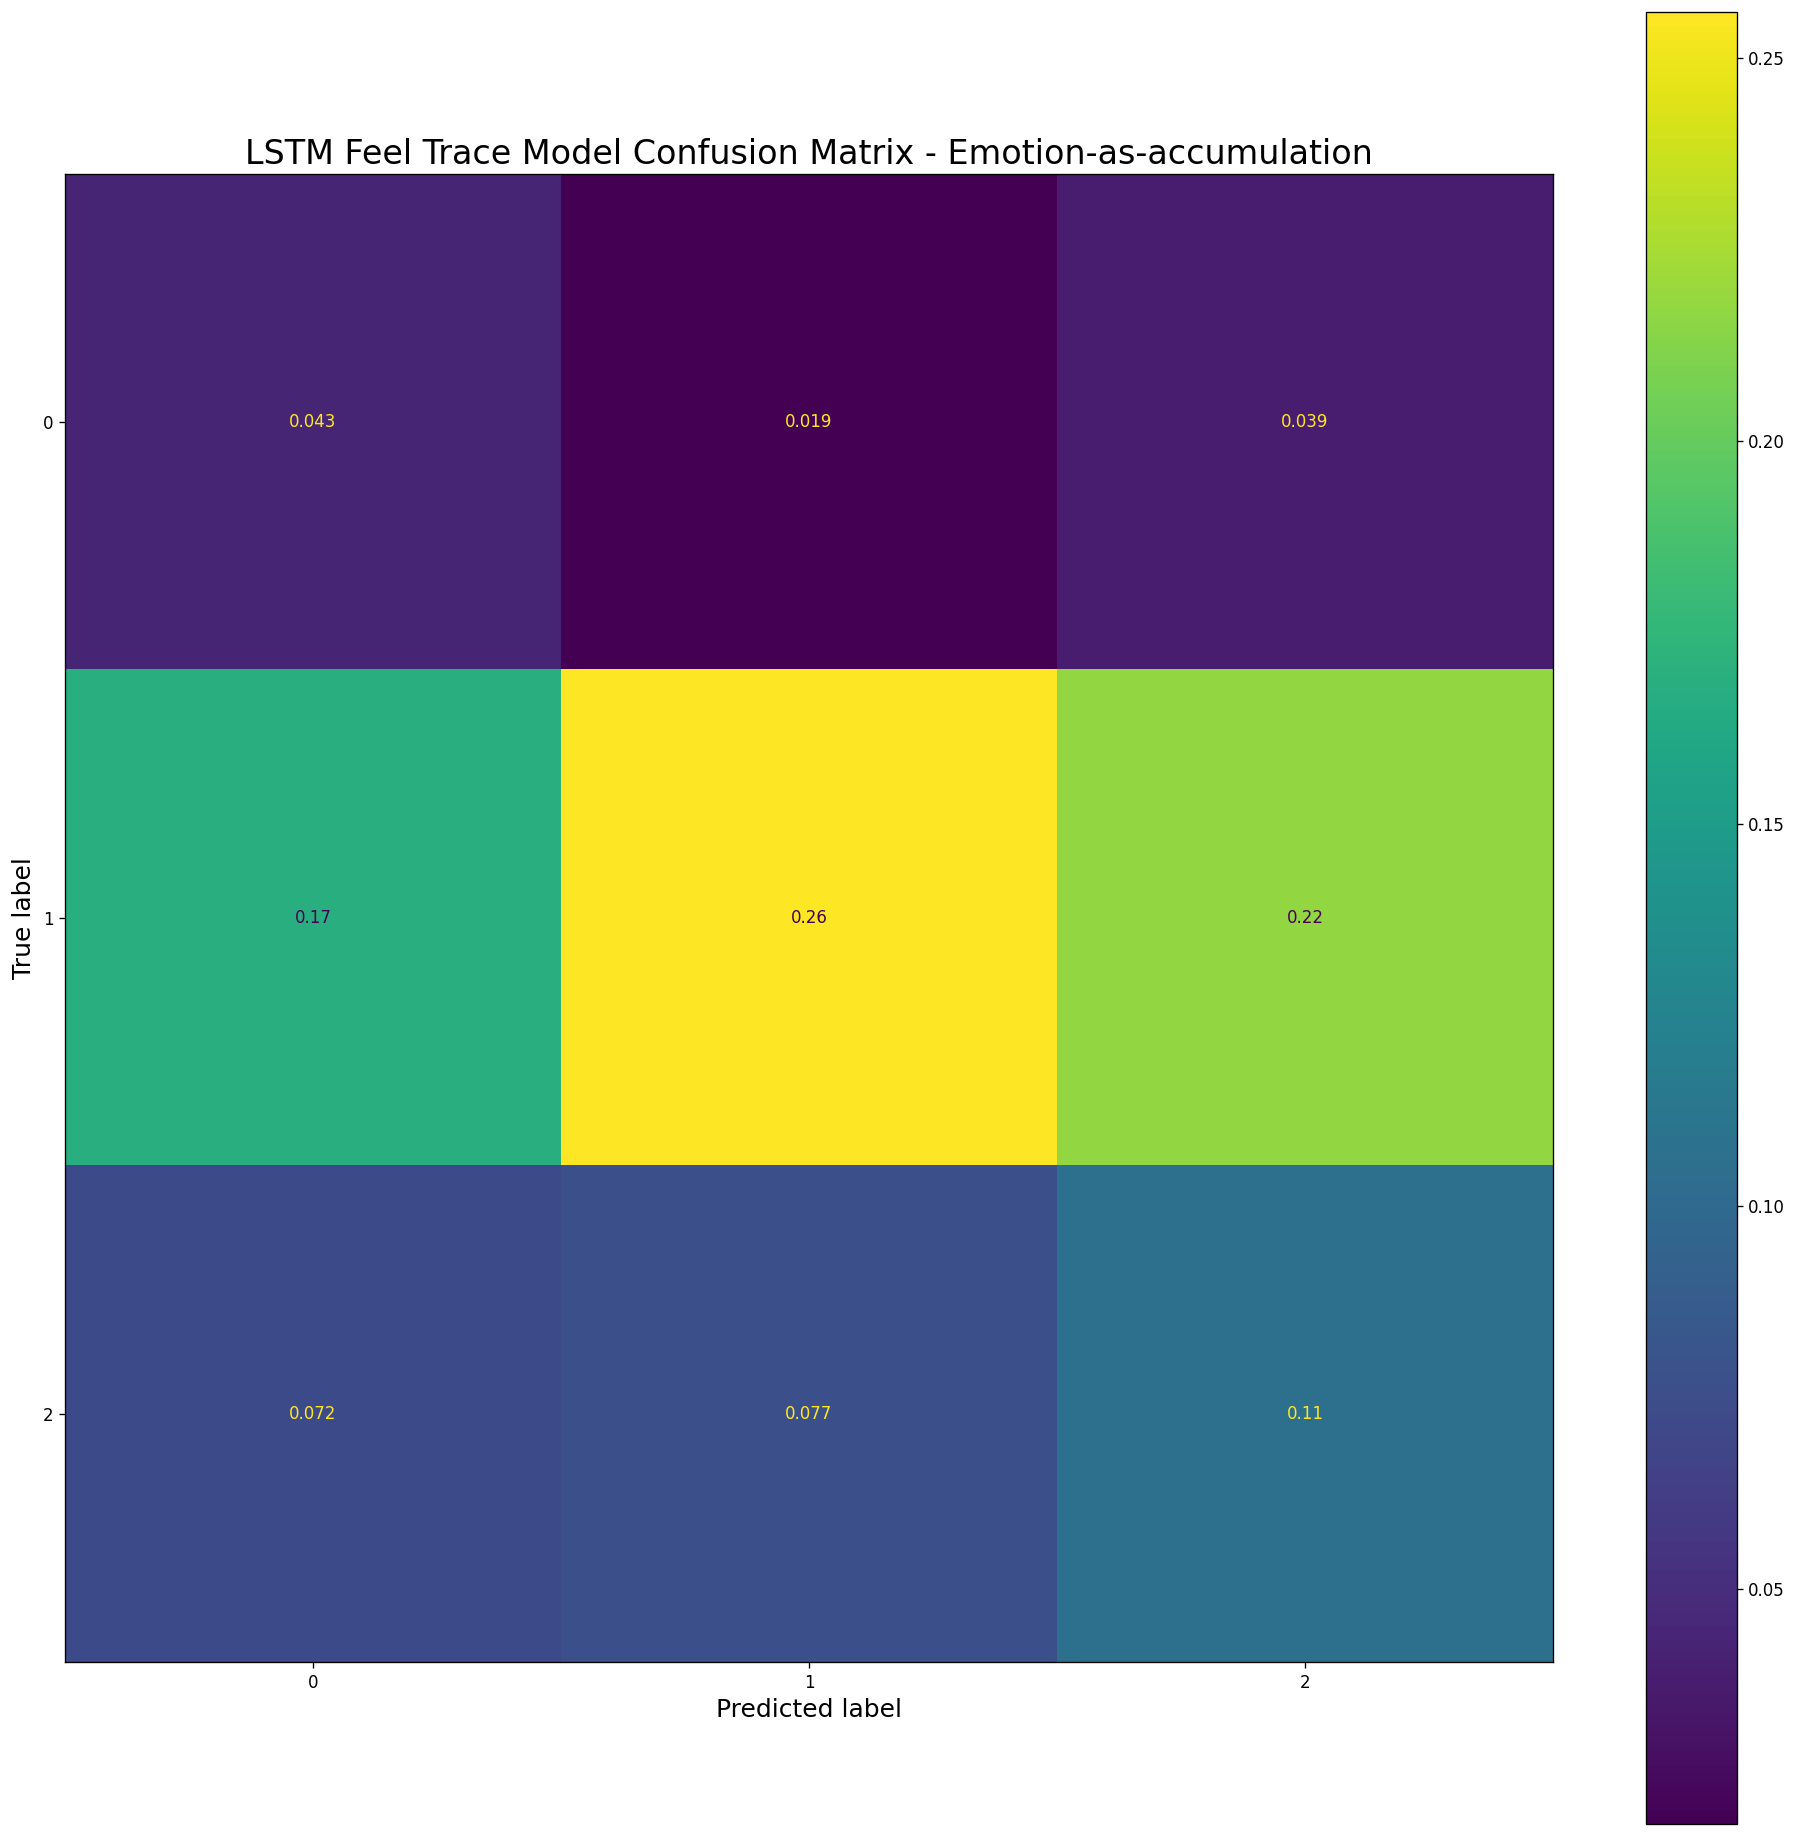

Training k=2
Training Classifier!
Train label distribution: [ 86 530 212]


100%|██████████| 7/7 [00:01<00:00,  4.25it/s]


Epoch:1,
Train Loss:1.0758440494537354,
Train Accuracy:0.3922619047619048,
Train Recall: 0.39218842991212305,
Train precision: 0.37737949050748043,
Train F1-Score:0.341815740879742,


100%|██████████| 7/7 [00:01<00:00,  3.94it/s]


Epoch:2,
Train Loss:1.0169199705123901,
Train Accuracy:0.4873511904761905,
Train Recall: 0.4714133843491964,
Train precision: 0.5087577840965005,
Train F1-Score:0.43190966692484106,


100%|██████████| 7/7 [00:01<00:00,  4.43it/s]


Epoch:3,
Train Loss:0.9803499579429626,
Train Accuracy:0.5337053571428572,
Train Recall: 0.5355172068227981,
Train precision: 0.5864082814499981,
Train F1-Score:0.5046222353752828,


100%|██████████| 7/7 [00:01<00:00,  4.63it/s]


Epoch:4,
Train Loss:0.9404519200325012,
Train Accuracy:0.5446428571428571,
Train Recall: 0.5526779851270152,
Train precision: 0.5475089574174609,
Train F1-Score:0.5409885878416925,


100%|██████████| 7/7 [00:01<00:00,  4.74it/s]


Epoch:5,
Train Loss:0.9076811075210571,
Train Accuracy:0.5808035714285714,
Train Recall: 0.5830445703440408,
Train precision: 0.5892667449615286,
Train F1-Score:0.5751269122694128,


100%|██████████| 7/7 [00:01<00:00,  4.86it/s]


Epoch:6,
Train Loss:0.8594663739204407,
Train Accuracy:0.629389880952381,
Train Recall: 0.6268887814806463,
Train precision: 0.6541141975063715,
Train F1-Score:0.6159515821448434,


100%|██████████| 7/7 [00:01<00:00,  4.75it/s]


Epoch:7,
Train Loss:0.8668521642684937,
Train Accuracy:0.6084821428571429,
Train Recall: 0.5997400574933994,
Train precision: 0.6253215155895328,
Train F1-Score:0.5873548837666294,


100%|██████████| 7/7 [00:01<00:00,  4.46it/s]


Epoch:8,
Train Loss:0.8409825563430786,
Train Accuracy:0.6117559523809524,
Train Recall: 0.6071773957832579,
Train precision: 0.6517770673701454,
Train F1-Score:0.5945928463700304,


100%|██████████| 7/7 [00:01<00:00,  4.39it/s]


Epoch:9,
Train Loss:0.7945866584777832,
Train Accuracy:0.6985119047619047,
Train Recall: 0.6978767891719999,
Train precision: 0.7009692861133159,
Train F1-Score:0.6890782208136959,


100%|██████████| 7/7 [00:01<00:00,  4.71it/s]


Epoch:10,
Train Loss:0.7808375358581543,
Train Accuracy:0.6461309523809524,
Train Recall: 0.6531911531452235,
Train precision: 0.6514515008279574,
Train F1-Score:0.6433944949907663,
Test label distribution: [ 22 132  53]
Precision: 0.42494102904319625
Recall: 0.40494568324757
F1-Score: 0.40793302988204555
Base line F1-Score: 0.25958702064896755
Accuracy: 0.5942028985507246
Metrics:
              precision    recall  f1-score   support

           0       0.14      0.14      0.14        22
           1       0.69      0.80      0.74       132
           2       0.44      0.28      0.34        53

    accuracy                           0.59       207
   macro avg       0.42      0.40      0.41       207
weighted avg       0.57      0.59      0.57       207



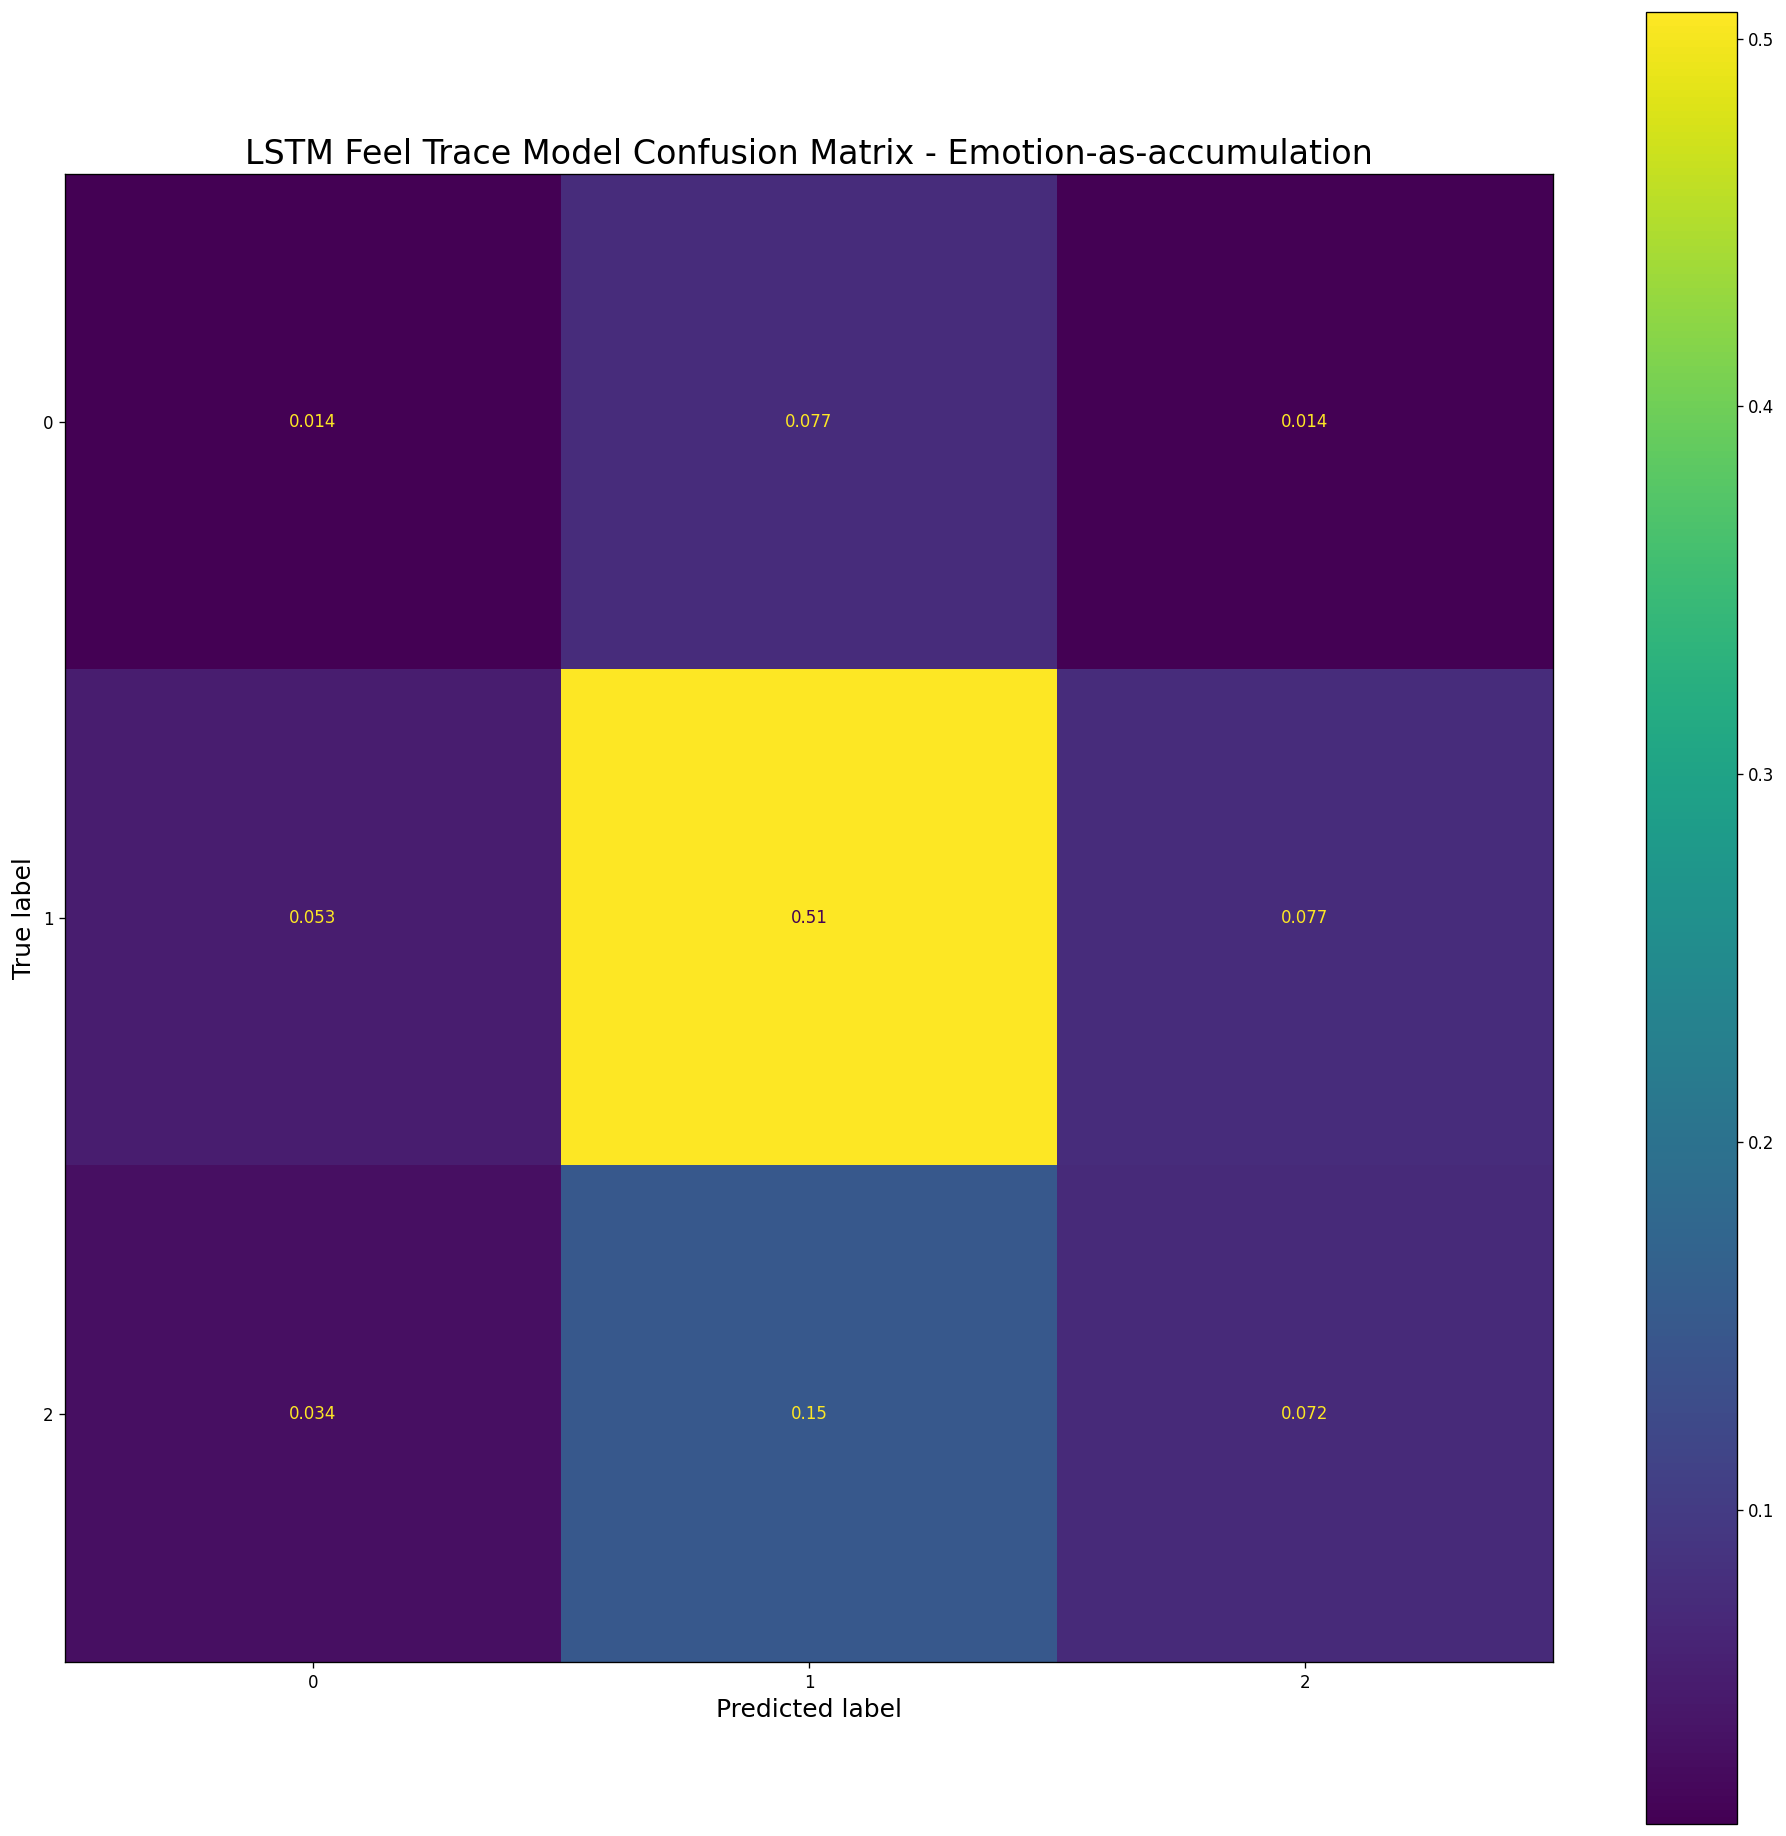

Training k=3
Training Classifier!
Train label distribution: [ 86 530 212]


100%|██████████| 7/7 [00:01<00:00,  4.84it/s]


Epoch:1,
Train Loss:1.080912470817566,
Train Accuracy:0.378125,
Train Recall: 0.38467083442425354,
Train precision: 0.44413029798069475,
Train F1-Score:0.30449264653436403,


100%|██████████| 7/7 [00:01<00:00,  4.44it/s]


Epoch:2,
Train Loss:1.0208016633987427,
Train Accuracy:0.4948660714285714,
Train Recall: 0.5016610131144851,
Train precision: 0.5850207033311604,
Train F1-Score:0.4620171502291034,


100%|██████████| 7/7 [00:01<00:00,  4.46it/s]


Epoch:3,
Train Loss:0.9728165864944458,
Train Accuracy:0.5473214285714285,
Train Recall: 0.5588418356423858,
Train precision: 0.5779270026158575,
Train F1-Score:0.5327859890134058,


100%|██████████| 7/7 [00:01<00:00,  4.28it/s]


Epoch:4,
Train Loss:0.9800848364830017,
Train Accuracy:0.49955357142857143,
Train Recall: 0.5006936098973701,
Train precision: 0.535042317801736,
Train F1-Score:0.48746573445187025,


100%|██████████| 7/7 [00:01<00:00,  4.39it/s]


Epoch:5,
Train Loss:0.9260841012001038,
Train Accuracy:0.5615327380952381,
Train Recall: 0.5689310765513889,
Train precision: 0.5722107853425749,
Train F1-Score:0.5565400504926853,


100%|██████████| 7/7 [00:01<00:00,  4.74it/s]


Epoch:6,
Train Loss:0.8649338483810425,
Train Accuracy:0.6175595238095238,
Train Recall: 0.618253769223883,
Train precision: 0.6242450173870353,
Train F1-Score:0.6141297232281117,


100%|██████████| 7/7 [00:01<00:00,  4.85it/s]


Epoch:7,
Train Loss:0.8820590972900391,
Train Accuracy:0.599702380952381,
Train Recall: 0.606558056539817,
Train precision: 0.6248321079581729,
Train F1-Score:0.5942285107283222,


100%|██████████| 7/7 [00:01<00:00,  4.69it/s]


Epoch:8,
Train Loss:0.8404564261436462,
Train Accuracy:0.638764880952381,
Train Recall: 0.6443757948122346,
Train precision: 0.6427358708354997,
Train F1-Score:0.6316915333252119,


100%|██████████| 7/7 [00:01<00:00,  4.72it/s]


Epoch:9,
Train Loss:0.8156290650367737,
Train Accuracy:0.6324404761904762,
Train Recall: 0.6272337675271139,
Train precision: 0.6392220452216624,
Train F1-Score:0.62050641557043,


100%|██████████| 7/7 [00:01<00:00,  4.50it/s]


Epoch:10,
Train Loss:0.8031761050224304,
Train Accuracy:0.6545386904761905,
Train Recall: 0.6555241226963945,
Train precision: 0.66873947764343,
Train F1-Score:0.6495156687112653,
Test label distribution: [ 22 132  53]
Precision: 0.3927926301623174
Recall: 0.3957975986277873
F1-Score: 0.36643356643356645
Base line F1-Score: 0.25958702064896755
Accuracy: 0.43478260869565216
Metrics:
              precision    recall  f1-score   support

           0       0.12      0.23      0.15        22
           1       0.74      0.43      0.55       132
           2       0.32      0.53      0.40        53

    accuracy                           0.43       207
   macro avg       0.39      0.40      0.37       207
weighted avg       0.57      0.43      0.47       207



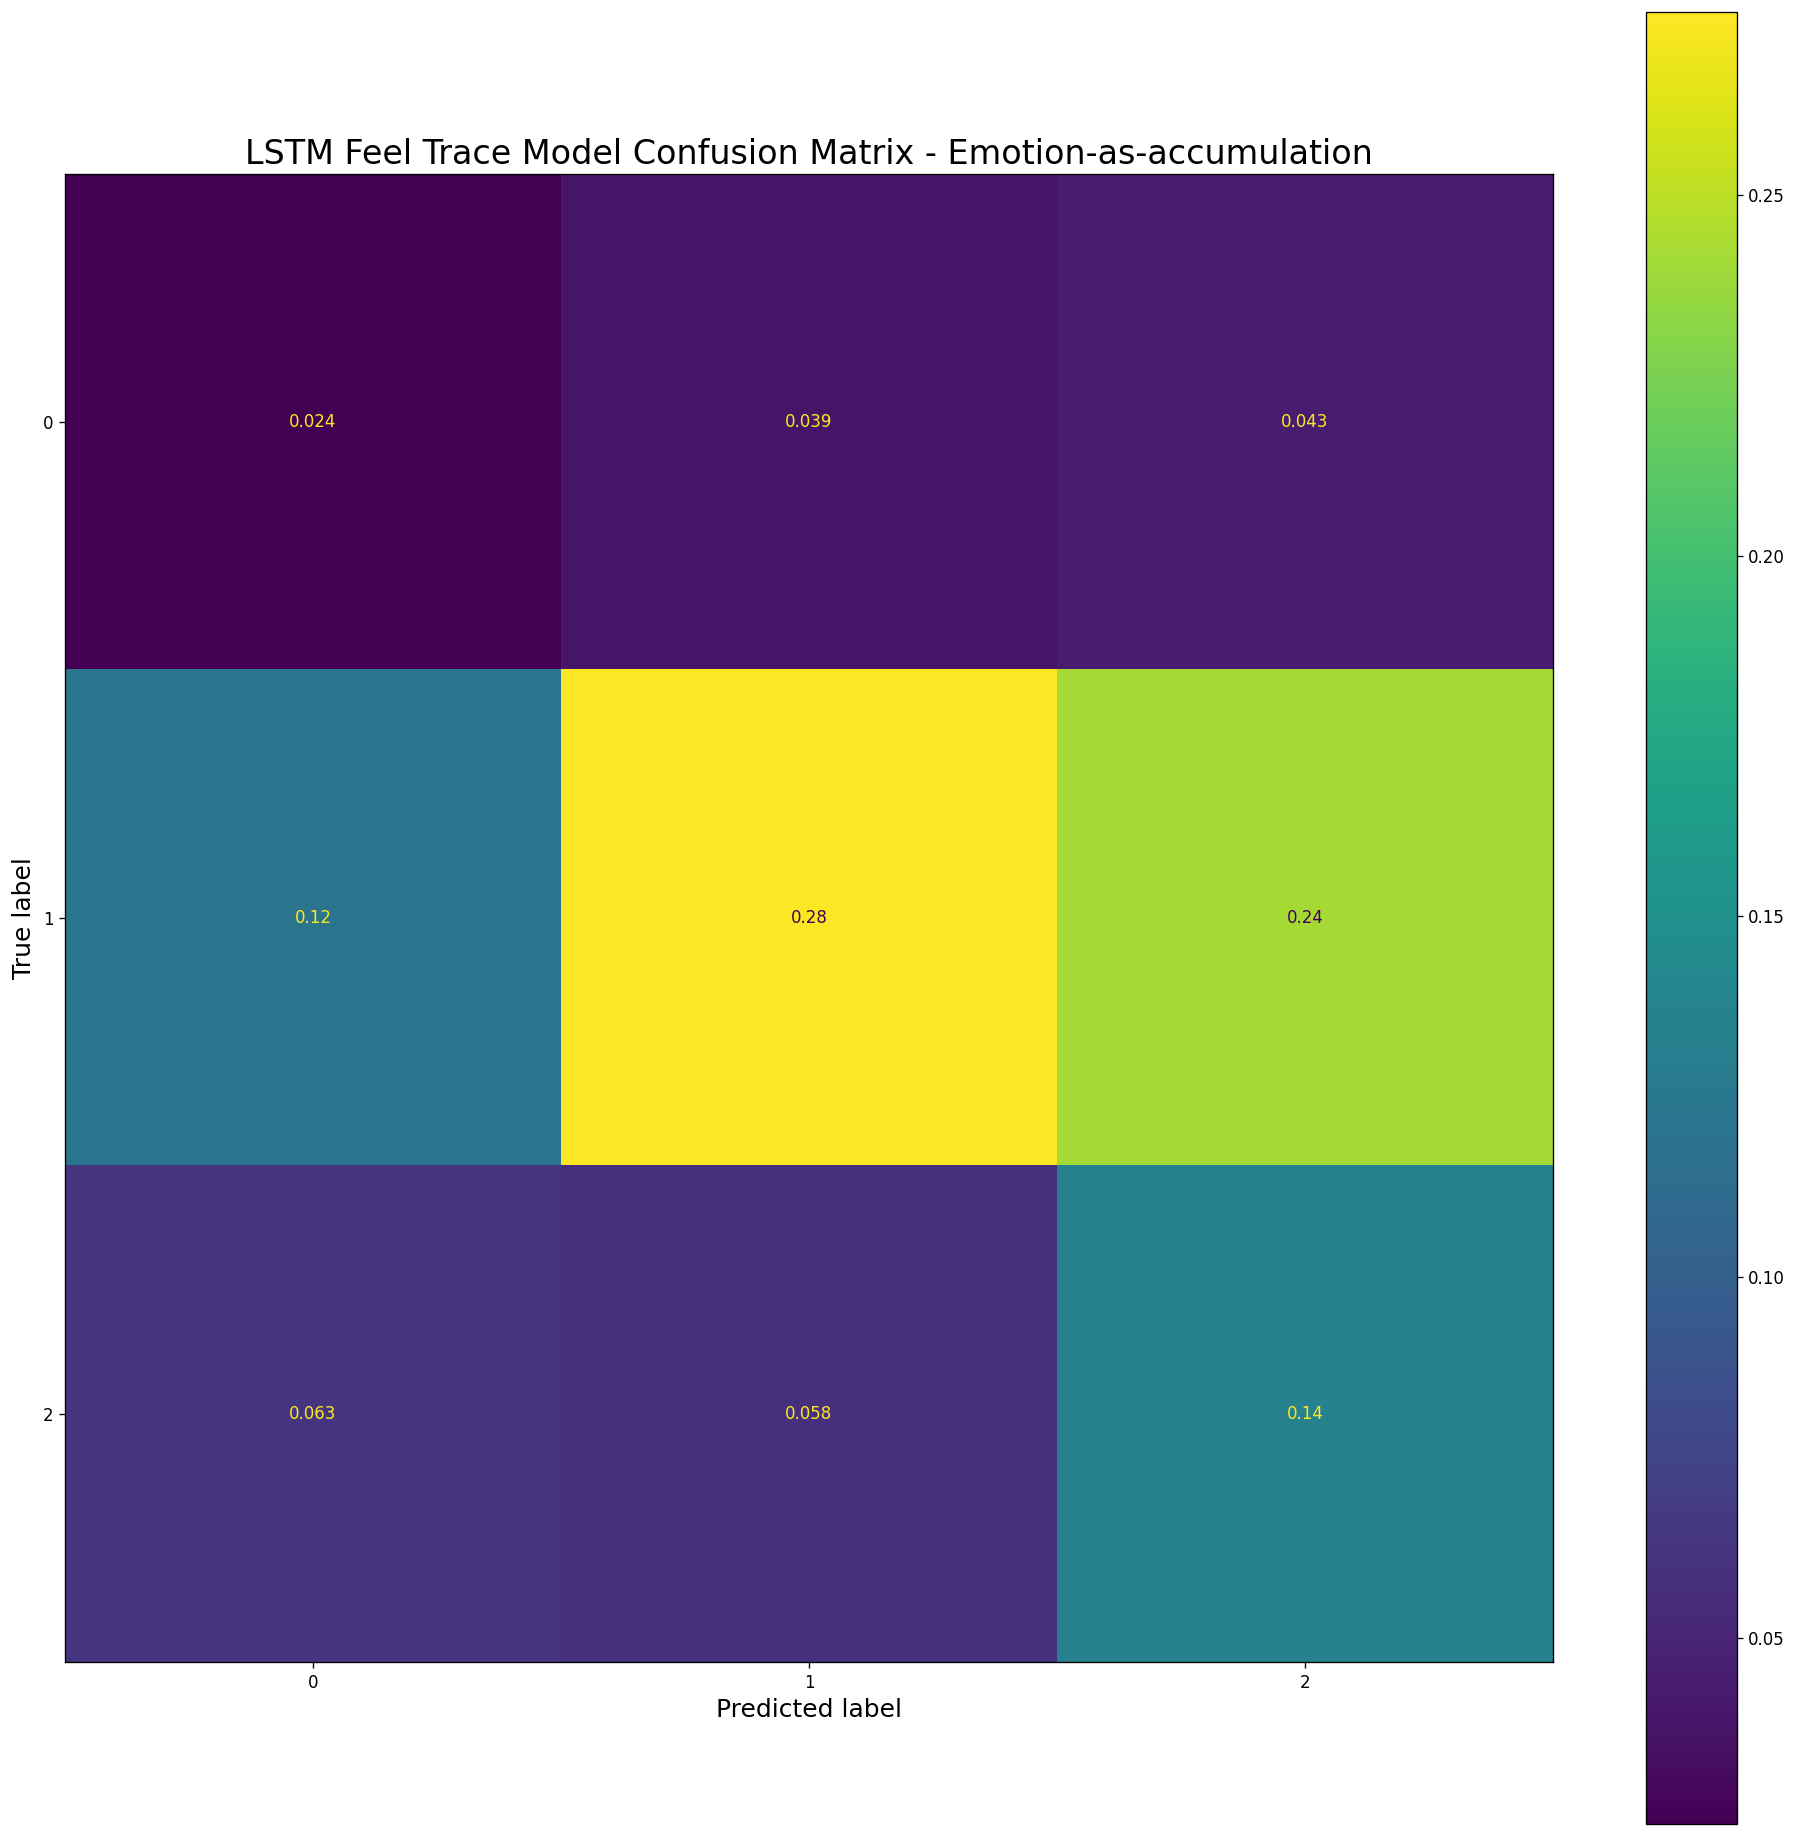

Training k=4
Training Classifier!
Train label distribution: [ 86 530 212]


100%|██████████| 7/7 [00:01<00:00,  4.36it/s]


Epoch:1,
Train Loss:1.096751093864441,
Train Accuracy:0.3746279761904762,
Train Recall: 0.35041267730580294,
Train precision: 0.3041060255453253,
Train F1-Score:0.2472612863854487,


100%|██████████| 7/7 [00:01<00:00,  4.35it/s]


Epoch:2,
Train Loss:1.073765754699707,
Train Accuracy:0.38586309523809526,
Train Recall: 0.37786799591066655,
Train precision: 0.3908184501772638,
Train F1-Score:0.3102765032549465,


100%|██████████| 7/7 [00:01<00:00,  4.67it/s]


Epoch:3,
Train Loss:1.0298436880111694,
Train Accuracy:0.4993303571428571,
Train Recall: 0.4944158632865633,
Train precision: 0.49703572599296947,
Train F1-Score:0.4804686453669279,


100%|██████████| 7/7 [00:01<00:00,  4.62it/s]


Epoch:4,
Train Loss:0.9875921607017517,
Train Accuracy:0.4973214285714286,
Train Recall: 0.5002153526659108,
Train precision: 0.5187612745465714,
Train F1-Score:0.4842080959418668,


100%|██████████| 7/7 [00:01<00:00,  4.46it/s]


Epoch:5,
Train Loss:0.9685166478157043,
Train Accuracy:0.5229166666666666,
Train Recall: 0.5346914120066227,
Train precision: 0.5311837486840256,
Train F1-Score:0.5106395119285077,


100%|██████████| 7/7 [00:01<00:00,  4.56it/s]


Epoch:6,
Train Loss:0.9154052138328552,
Train Accuracy:0.5930059523809524,
Train Recall: 0.5927228494025272,
Train precision: 0.6030165719811152,
Train F1-Score:0.583624790686596,


100%|██████████| 7/7 [00:01<00:00,  4.74it/s]


Epoch:7,
Train Loss:0.8901264071464539,
Train Accuracy:0.6078869047619048,
Train Recall: 0.6059006980716889,
Train precision: 0.6206803023707607,
Train F1-Score:0.5995559310552991,


100%|██████████| 7/7 [00:01<00:00,  4.92it/s]


Epoch:8,
Train Loss:0.8641905784606934,
Train Accuracy:0.5952380952380952,
Train Recall: 0.5980468420967676,
Train precision: 0.6135500314871907,
Train F1-Score:0.5892401027282645,


100%|██████████| 7/7 [00:01<00:00,  4.78it/s]


Epoch:9,
Train Loss:0.8263395428657532,
Train Accuracy:0.6573660714285714,
Train Recall: 0.6621479503086566,
Train precision: 0.670559960273252,
Train F1-Score:0.6535262660826008,


100%|██████████| 7/7 [00:01<00:00,  4.75it/s]


Epoch:10,
Train Loss:0.8049491047859192,
Train Accuracy:0.6566220238095238,
Train Recall: 0.6547957422279397,
Train precision: 0.6563881621265286,
Train F1-Score:0.6480132728540459,
Test label distribution: [ 22 132  53]
Precision: 0.41517857142857145
Recall: 0.45383076043453396
F1-Score: 0.3817414735407391
Base line F1-Score: 0.25958702064896755
Accuracy: 0.4106280193236715
Metrics:
              precision    recall  f1-score   support

           0       0.16      0.45      0.23        22
           1       0.71      0.34      0.46       132
           2       0.38      0.57      0.45        53

    accuracy                           0.41       207
   macro avg       0.42      0.45      0.38       207
weighted avg       0.57      0.41      0.43       207



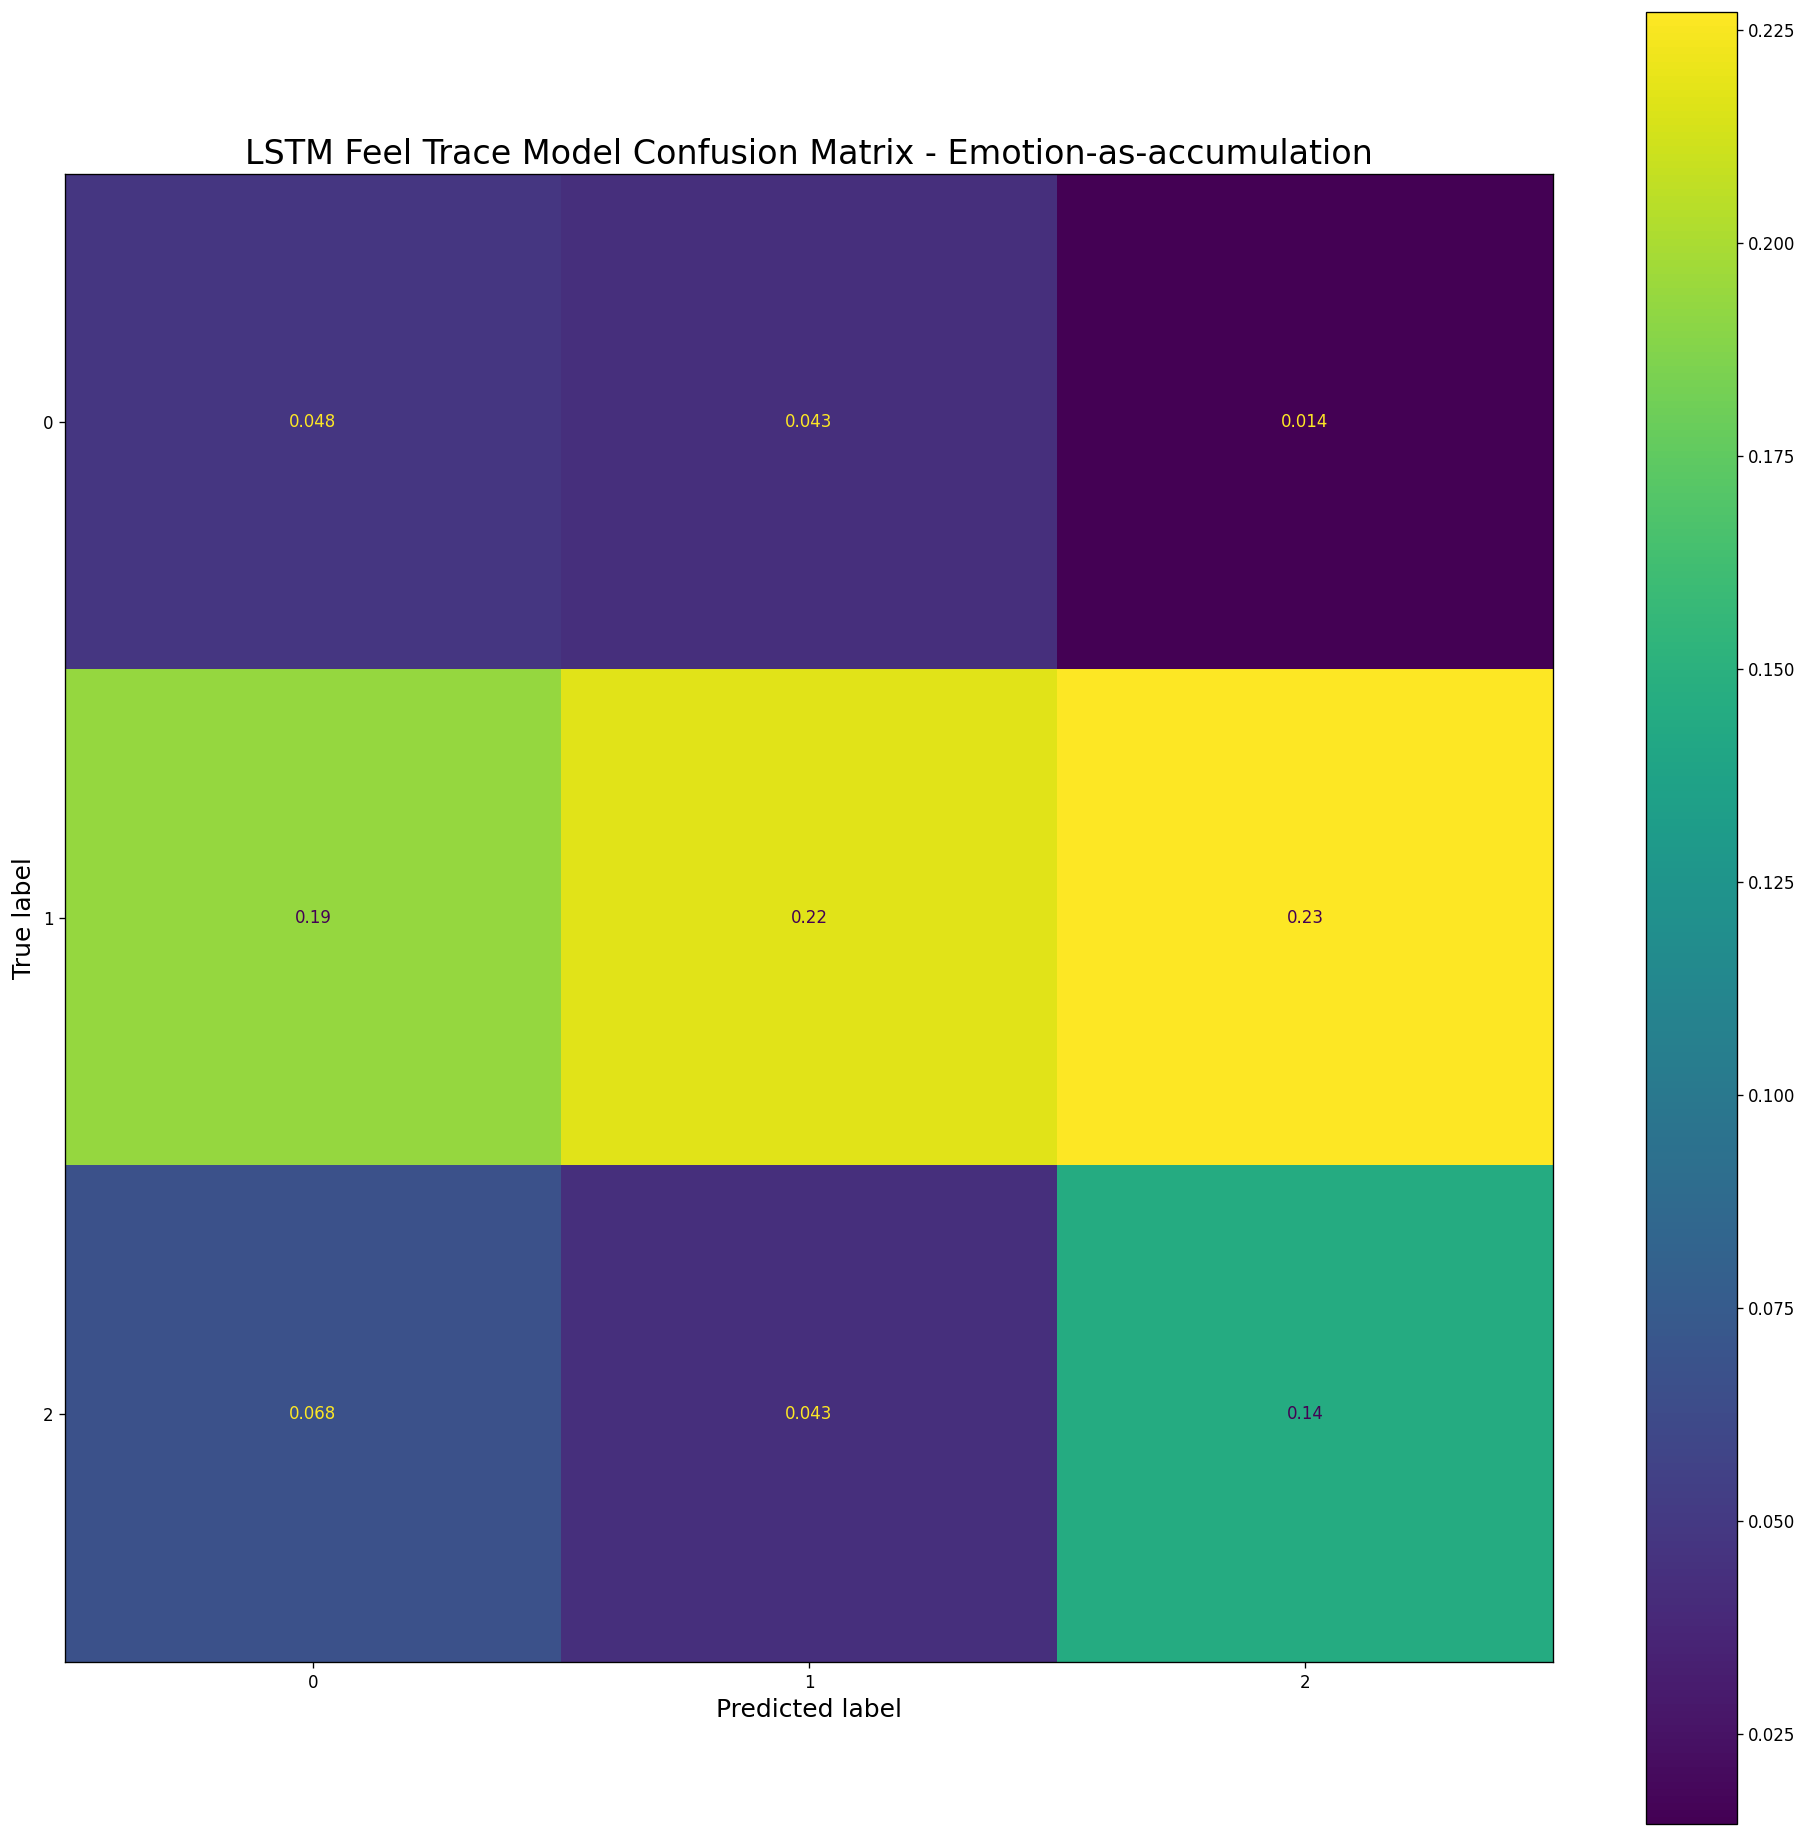

Accuracy, Average accuracy: [0.2898550724637681, 0.4057971014492754, 0.5942028985507246, 0.43478260869565216, 0.4106280193236715], 0.4270531400966183
F1-Score, Average F1-Score: [0.26735055895475685, 0.36110436893203884, 0.40793302988204555, 0.36643356643356645, 0.3817414735407391], 0.3569125995486294


In [33]:
k_acc = [] # accuracies for each fold
k_f1 = [] # f1 score for each fold

for cur_k in range(len(indices)):
    print(f"Training k={cur_k}")
    train_index, test_index = indices[cur_k]

    classifier_model = classifier(num_features=num_features, num_hidden=classifier_hidden, dropout=0.8, n_labels=num_classes)


    encoded_train_features = eeg_features[train_index]
    print('Training Classifier!')
    classifier_train_metrics = train_classifier(classifier_model, classifier_train_epochs, batch_size=128, learning_rate=classifier_learning_rate, features=encoded_train_features, labels=labels[train_index])


    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    test_features, test_labels =  eeg_features[test_index], labels[test_index]
    print(f"Test label distribution: {np.bincount(test_labels, minlength=num_classes)}")
    encoded_test_features = test_features

    with torch.no_grad():
        classifier_model.eval()
        x_encoded  = torch.from_numpy(encoded_test_features).float().to(device)
        y = test_labels
        y_hat = classifier_model(x_encoded)
        y_hat = F.softmax(y_hat.detach(), dim=-1).cpu().numpy()
        preds = y_hat

    fig, axs = plt.subplots(figsize=(20,20), dpi=120)
    axs.set_title(f"LSTM Feel Trace Model Confusion Matrix - Emotion-as-{label_type}", fontsize=20)
    axs.set_xlabel("Predicted Label", fontsize=15)
    axs.set_ylabel("True Label", fontsize=15)


    prf = precision_recall_fscore_support(test_labels, np.array([x.argmax() for x in preds]), average='macro', zero_division=0)
    base_line = precision_recall_fscore_support(test_labels, np.array([1 for x in preds]), average='macro', zero_division=0)
    acc = np.mean(test_labels == np.array([x.argmax() for x in preds]))

    print(f"Precision: {prf[0]}")
    print(f"Recall: {prf[1]}")
    print(f"F1-Score: {prf[2]}")
    print(f"Base line F1-Score: {base_line[2]}")
    print(f"Accuracy: {acc}")
    print('Metrics:')
    print(classification_report(test_labels, np.array([x.argmax() for x in preds])))

    k_acc.append(acc)
    k_f1.append(prf[2])

    cm = confusion_matrix(test_labels, [x.argmax() for x in preds], labels=np.arange(num_classes), normalize='all')
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.arange(num_classes))

    disp.plot(ax=axs)
    plt.show()

print(f"Accuracy, Average accuracy: {k_acc}, {np.mean(k_acc)}")
print(f"F1-Score, Average F1-Score: {k_f1}, {np.mean(k_f1)}")

## Train Regression Loop


Training k=0
Training Regression!


100%|██████████| 7/7 [00:01<00:00,  4.16it/s]


Epoch:1,
Train Loss:9.037419319152832


100%|██████████| 7/7 [00:01<00:00,  4.44it/s]


Epoch:2,
Train Loss:2.3518271446228027


100%|██████████| 7/7 [00:01<00:00,  4.94it/s]


Epoch:3,
Train Loss:0.9394149780273438


100%|██████████| 7/7 [00:01<00:00,  4.87it/s]


Epoch:4,
Train Loss:0.2918173670768738


100%|██████████| 7/7 [00:01<00:00,  4.70it/s]


Epoch:5,
Train Loss:0.26980575919151306


100%|██████████| 7/7 [00:01<00:00,  4.60it/s]


Epoch:6,
Train Loss:0.09796248376369476


100%|██████████| 7/7 [00:01<00:00,  4.72it/s]


Epoch:7,
Train Loss:0.10658399760723114


100%|██████████| 7/7 [00:01<00:00,  4.85it/s]


Epoch:8,
Train Loss:0.08154857903718948


100%|██████████| 7/7 [00:01<00:00,  4.72it/s]


Epoch:9,
Train Loss:0.06475667655467987


100%|██████████| 7/7 [00:01<00:00,  4.81it/s]


Epoch:10,
Train Loss:0.06862878799438477


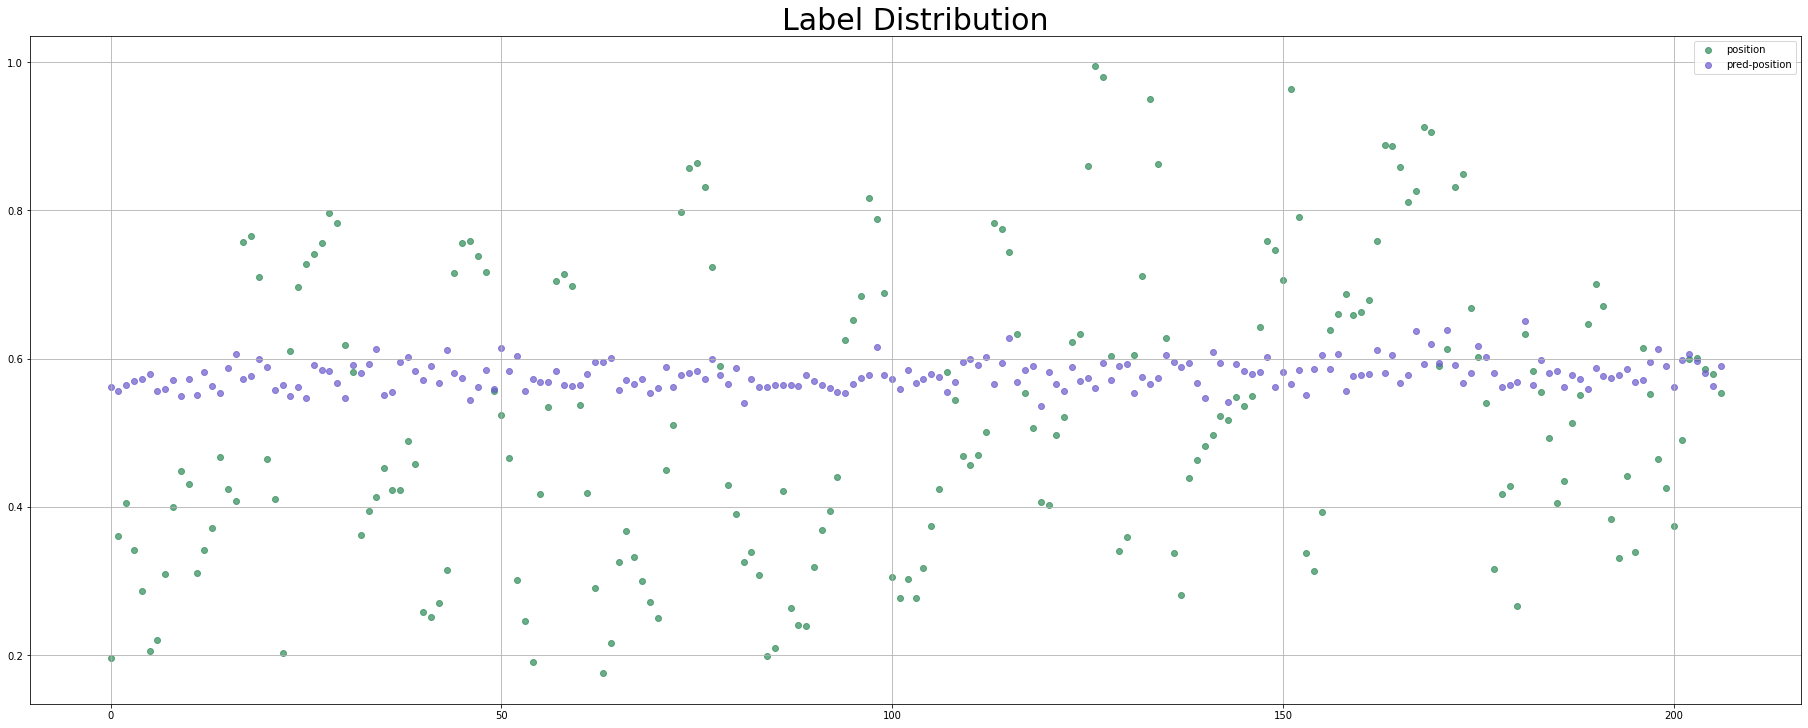

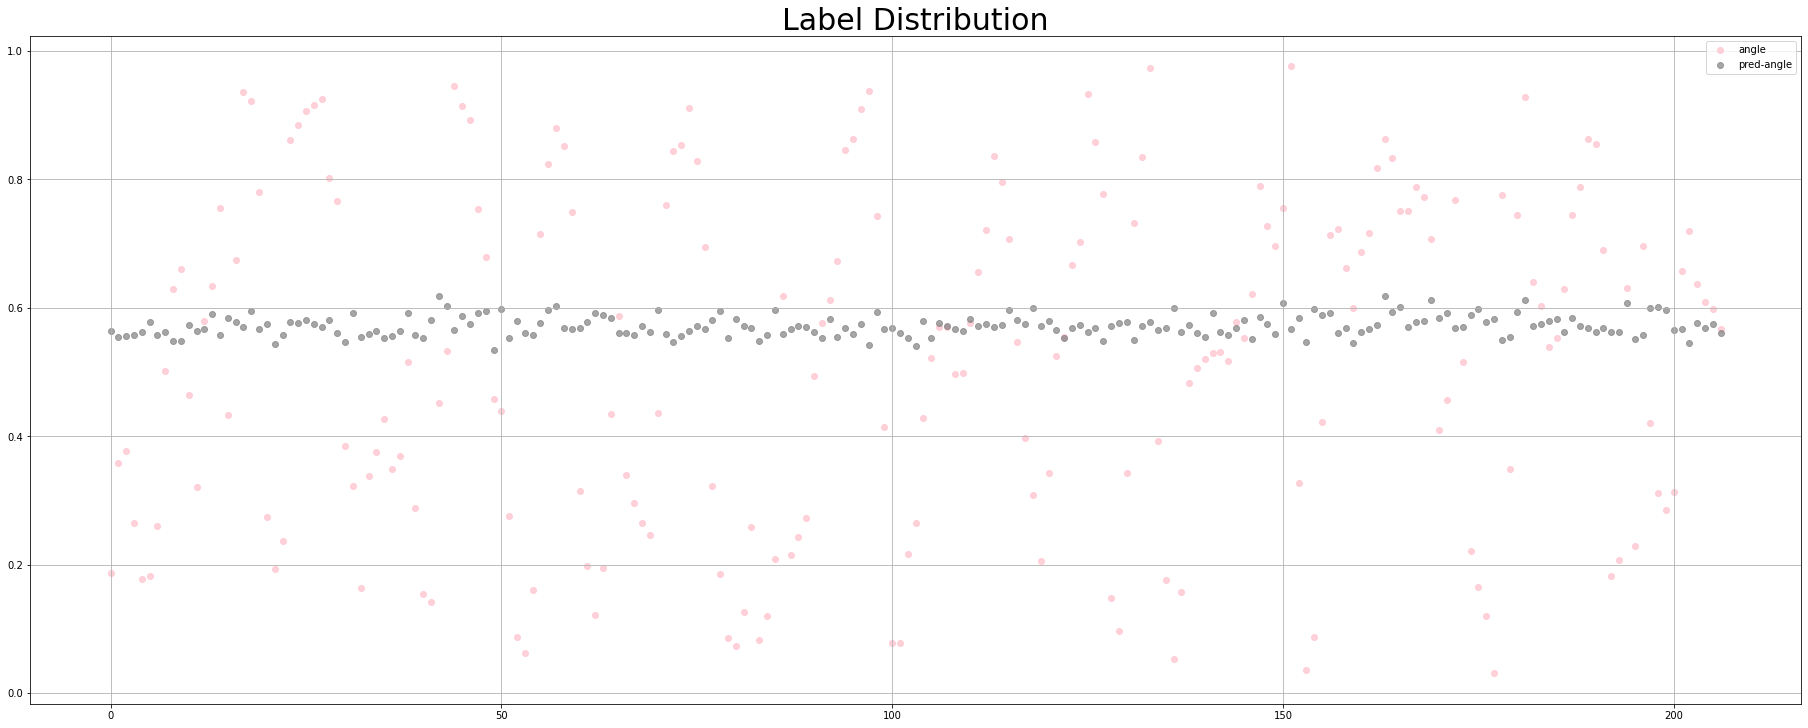

MSE: [0.03979764 0.06971327]
Training k=1
Training Regression!


100%|██████████| 7/7 [00:01<00:00,  4.73it/s]


Epoch:1,
Train Loss:2.324730157852173


100%|██████████| 7/7 [00:01<00:00,  4.39it/s]


Epoch:2,
Train Loss:0.3870231807231903


100%|██████████| 7/7 [00:01<00:00,  4.67it/s]


Epoch:3,
Train Loss:0.13813447952270508


100%|██████████| 7/7 [00:01<00:00,  4.77it/s]


Epoch:4,
Train Loss:0.180853471159935


100%|██████████| 7/7 [00:01<00:00,  4.63it/s]


Epoch:5,
Train Loss:0.13863058388233185


100%|██████████| 7/7 [00:01<00:00,  4.63it/s]


Epoch:6,
Train Loss:0.06585380434989929


100%|██████████| 7/7 [00:01<00:00,  4.60it/s]


Epoch:7,
Train Loss:0.07211942225694656


100%|██████████| 7/7 [00:01<00:00,  4.65it/s]


Epoch:8,
Train Loss:0.06398823112249374


100%|██████████| 7/7 [00:01<00:00,  4.84it/s]


Epoch:9,
Train Loss:0.0636301264166832


100%|██████████| 7/7 [00:01<00:00,  4.45it/s]


Epoch:10,
Train Loss:0.06032406538724899


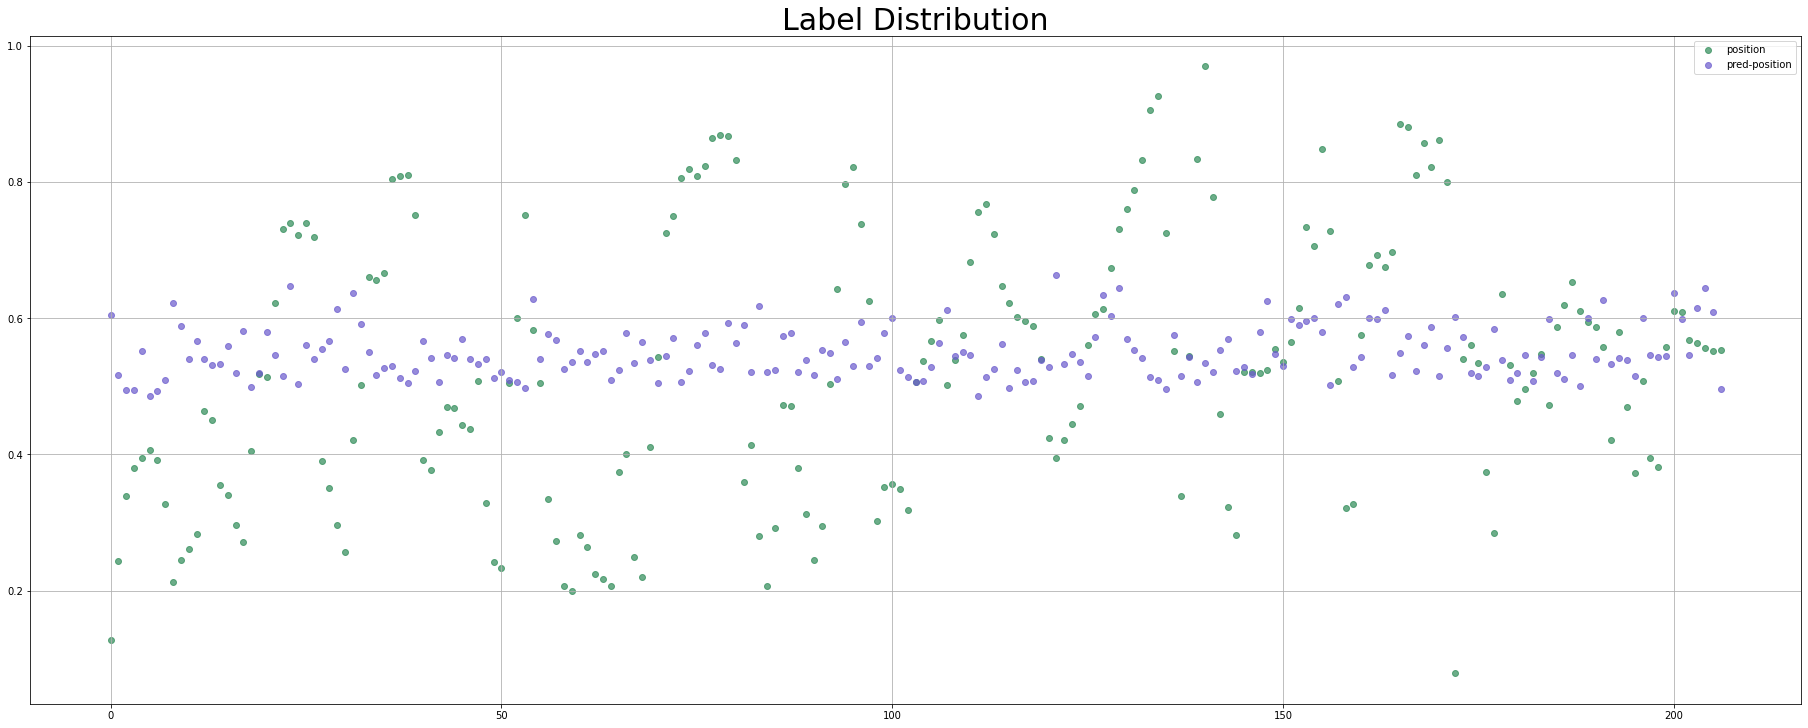

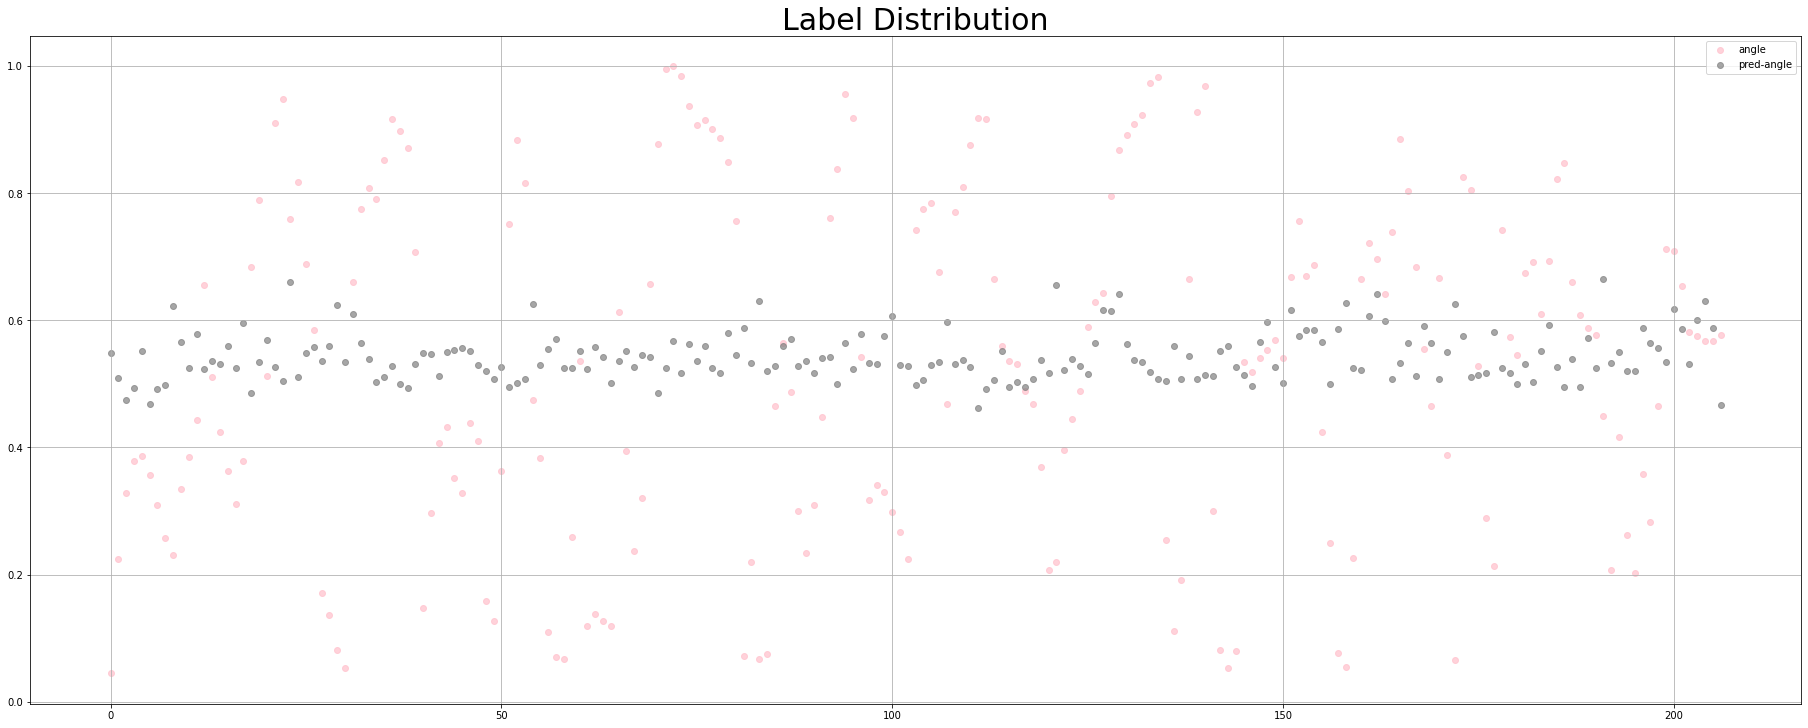

MSE: [0.03942613 0.07558765]
Training k=2
Training Regression!


100%|██████████| 7/7 [00:01<00:00,  4.65it/s]


Epoch:1,
Train Loss:3.844411849975586


100%|██████████| 7/7 [00:01<00:00,  4.61it/s]


Epoch:2,
Train Loss:0.5162596702575684


100%|██████████| 7/7 [00:01<00:00,  4.55it/s]


Epoch:3,
Train Loss:0.1793397217988968


100%|██████████| 7/7 [00:01<00:00,  4.39it/s]


Epoch:4,
Train Loss:0.17515268921852112


100%|██████████| 7/7 [00:01<00:00,  4.42it/s]


Epoch:5,
Train Loss:0.1949721723794937


100%|██████████| 7/7 [00:01<00:00,  4.54it/s]


Epoch:6,
Train Loss:0.1477494239807129


100%|██████████| 7/7 [00:01<00:00,  4.67it/s]


Epoch:7,
Train Loss:0.08582893759012222


100%|██████████| 7/7 [00:01<00:00,  4.44it/s]


Epoch:8,
Train Loss:0.059281349182128906


100%|██████████| 7/7 [00:01<00:00,  4.56it/s]


Epoch:9,
Train Loss:0.0659676194190979


100%|██████████| 7/7 [00:01<00:00,  4.69it/s]


Epoch:10,
Train Loss:0.06357287615537643


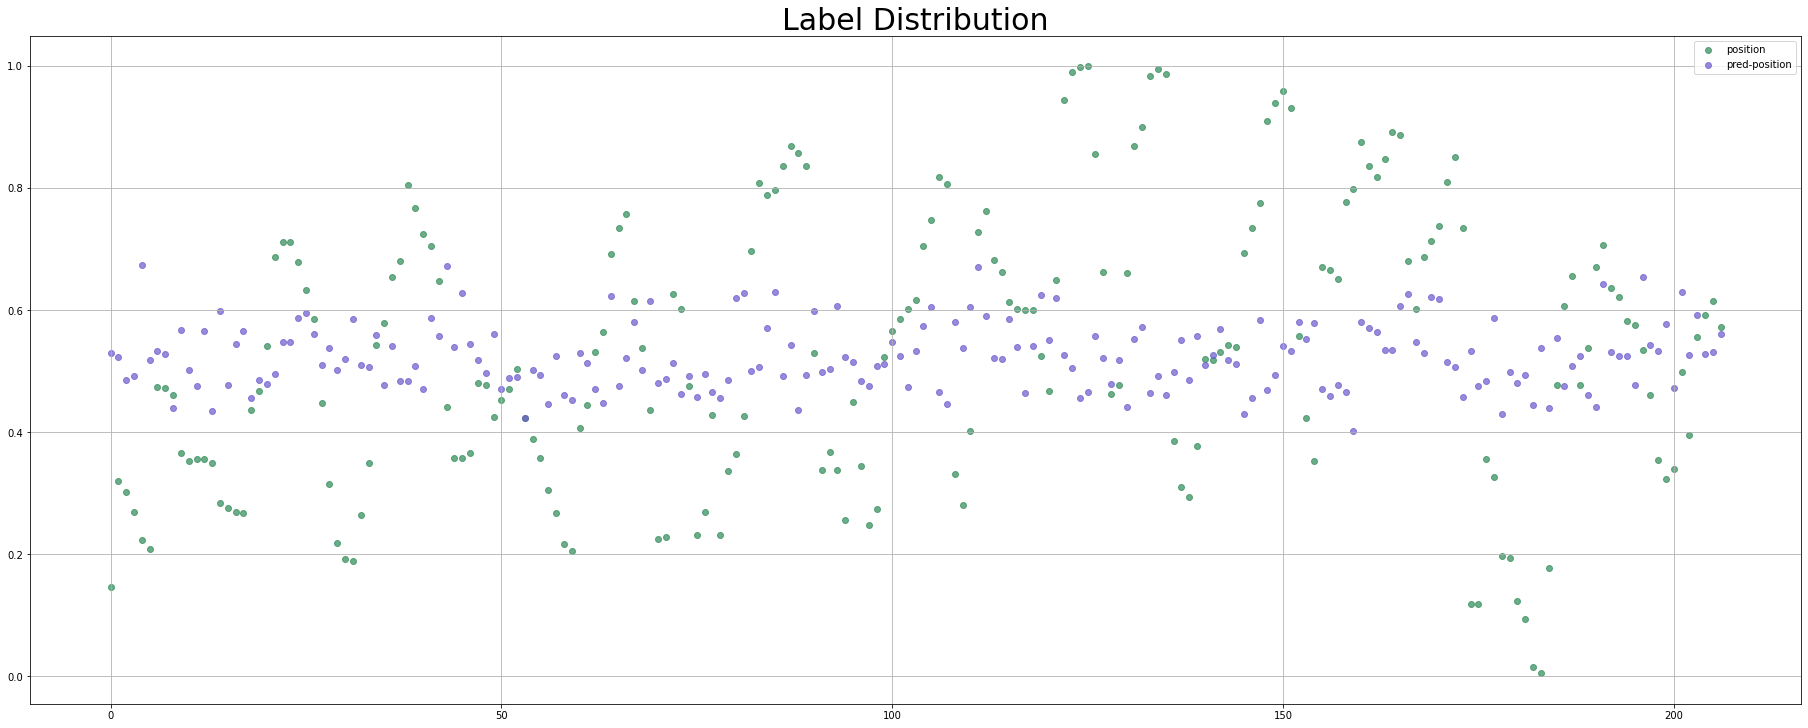

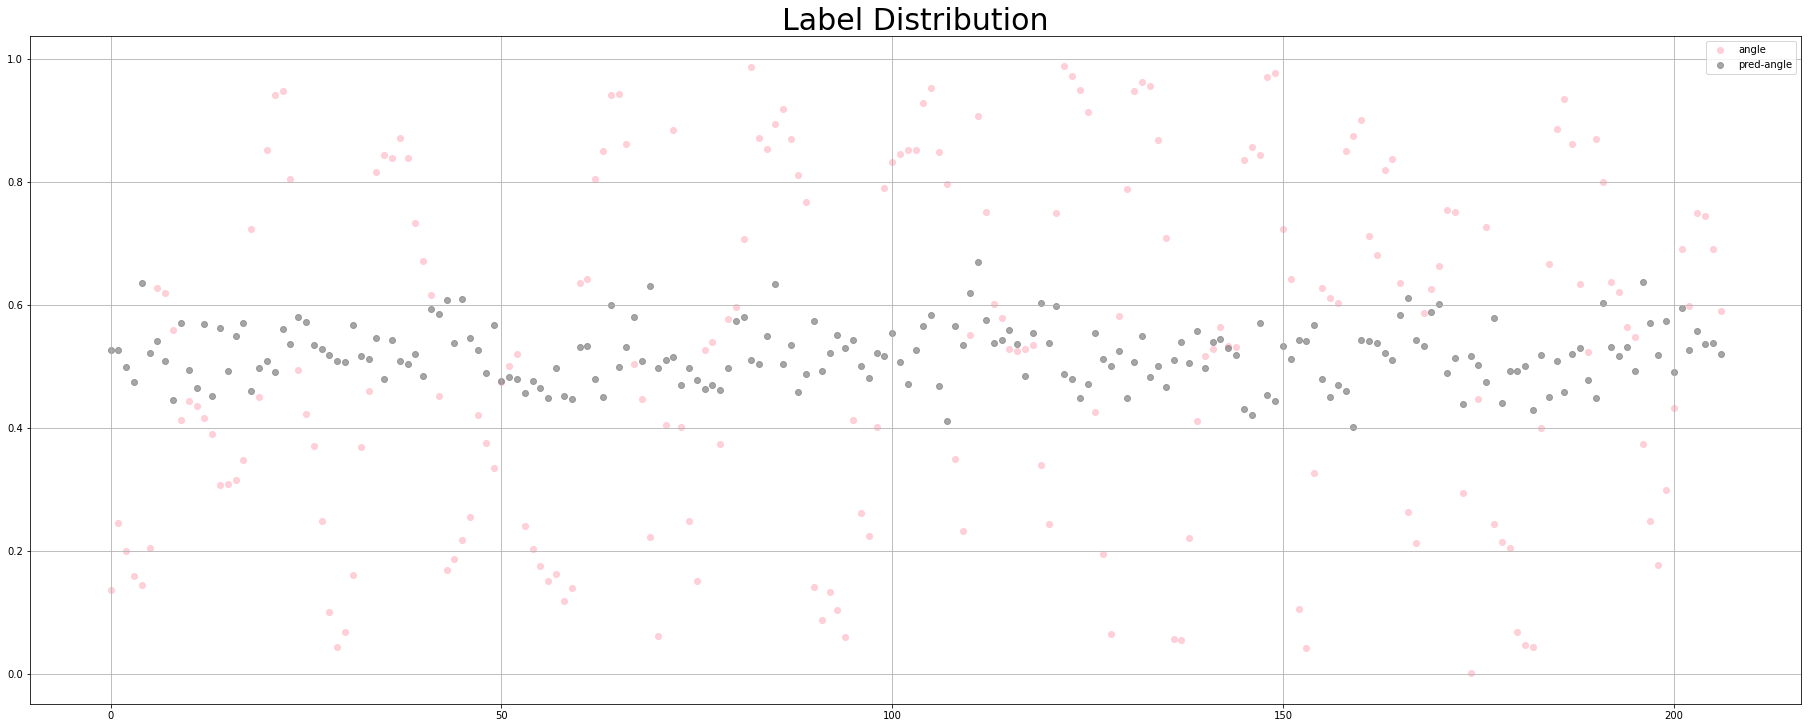

MSE: [0.05249487 0.08355661]
Training k=3
Training Regression!


100%|██████████| 7/7 [00:01<00:00,  4.29it/s]


Epoch:1,
Train Loss:23.67951774597168


100%|██████████| 7/7 [00:01<00:00,  4.55it/s]


Epoch:2,
Train Loss:5.547661304473877


100%|██████████| 7/7 [00:01<00:00,  4.51it/s]


Epoch:3,
Train Loss:1.0089409351348877


100%|██████████| 7/7 [00:01<00:00,  4.32it/s]


Epoch:4,
Train Loss:1.418595314025879


100%|██████████| 7/7 [00:01<00:00,  4.38it/s]


Epoch:5,
Train Loss:0.3120329976081848


100%|██████████| 7/7 [00:01<00:00,  4.69it/s]


Epoch:6,
Train Loss:0.07376321405172348


100%|██████████| 7/7 [00:01<00:00,  4.66it/s]


Epoch:7,
Train Loss:0.1074317917227745


100%|██████████| 7/7 [00:01<00:00,  4.55it/s]


Epoch:8,
Train Loss:0.08988102525472641


100%|██████████| 7/7 [00:01<00:00,  4.58it/s]


Epoch:9,
Train Loss:0.06739392131567001


100%|██████████| 7/7 [00:01<00:00,  4.52it/s]


Epoch:10,
Train Loss:0.06499888747930527


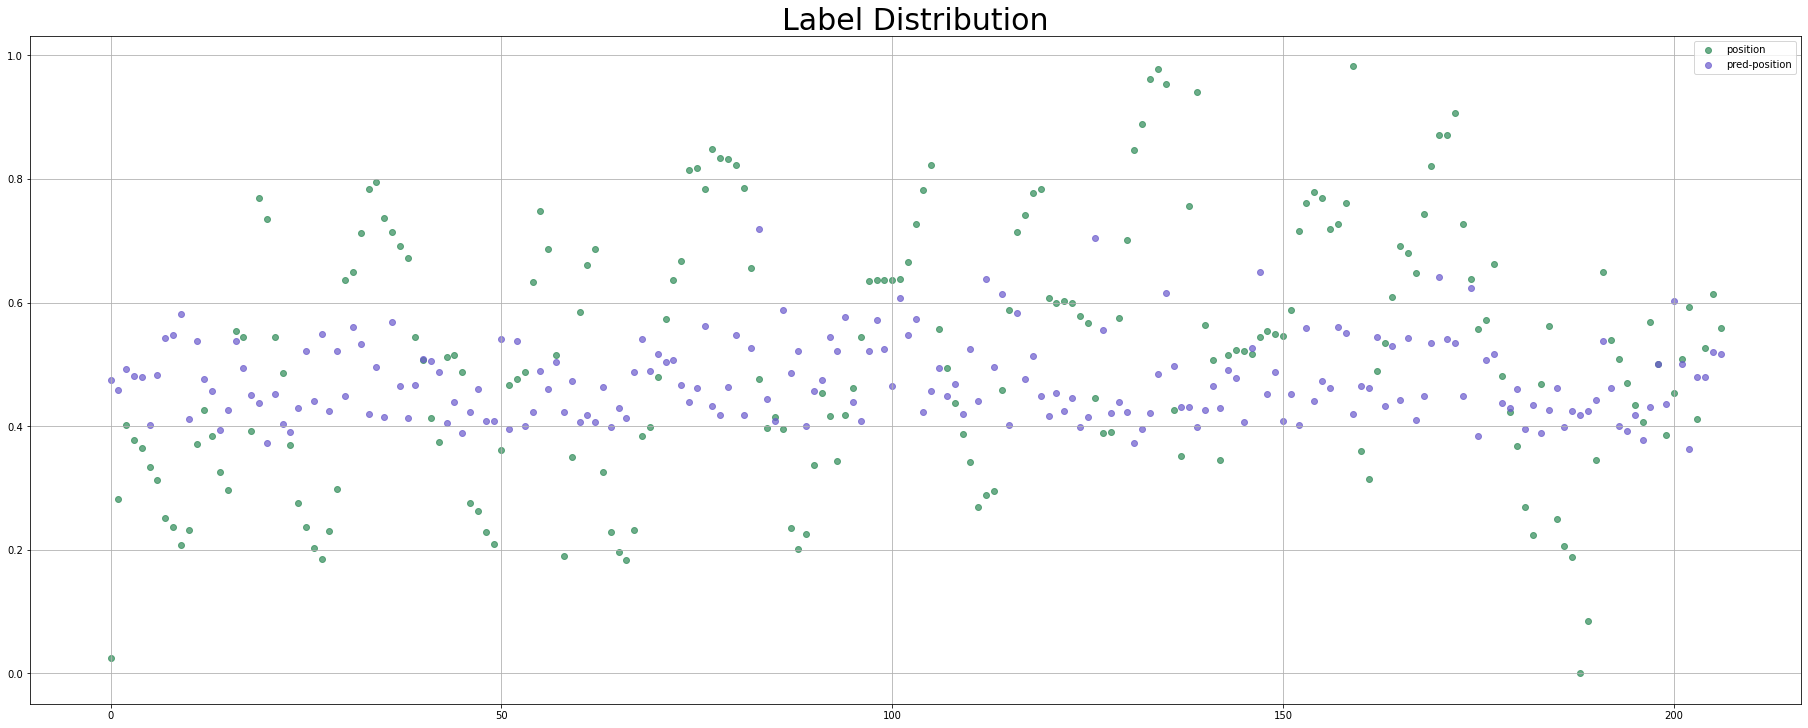

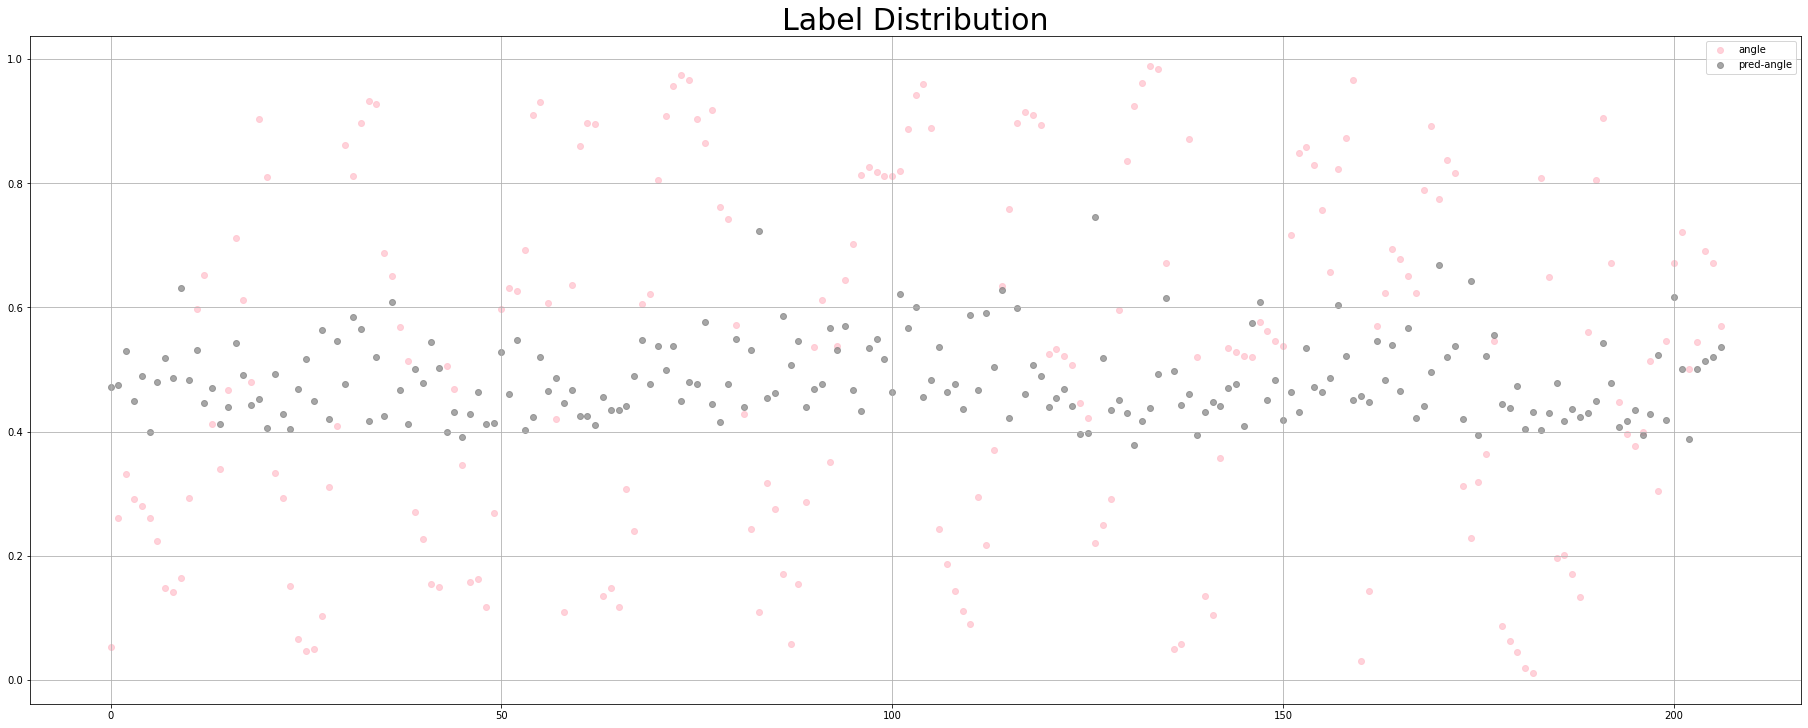

MSE: [0.04571657 0.08443164]
Training k=4
Training Regression!


100%|██████████| 7/7 [00:01<00:00,  4.53it/s]


Epoch:1,
Train Loss:1.3658711910247803


100%|██████████| 7/7 [00:01<00:00,  4.60it/s]


Epoch:2,
Train Loss:0.3197513222694397


100%|██████████| 7/7 [00:01<00:00,  4.61it/s]


Epoch:3,
Train Loss:0.19878344237804413


  0%|          | 0/7 [00:00<?, ?it/s]


KeyboardInterrupt: 

In [79]:
k_mse = [] # mse for each fold

for cur_k in range(len(indices)):
    print(f"Training k={cur_k}")
    train_index, test_index = indices[cur_k]

    classifier_model = classifier(num_features=num_features, num_hidden=classifier_hidden, dropout=0.8, n_labels=2)


    encoded_train_features = eeg_features[train_index]
    print('Training Regression!')
    classifier_train_metrics = train_regressor(classifier_model, classifier_train_epochs, batch_size=128, learning_rate=classifier_learning_rate, features=encoded_train_features, labels=labels[train_index])


    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    test_features, test_labels =  eeg_features[test_index], labels[test_index]
    encoded_test_features = test_features

    with torch.no_grad():
        classifier_model.eval()
        x_encoded  = torch.from_numpy(encoded_test_features).float().to(device)
        y = test_labels
        y_hat = classifier_model(x_encoded)
        y_hat = y_hat.detach().cpu().numpy()
        preds = y_hat


    fsize = 30

    fig, axes = plt.subplots(figsize=(25,10), nrows=1, ncols=1, sharey='row', sharex='row', gridspec_kw = {'wspace':0.01, 'hspace':0}, constrained_layout=True )
    axes.scatter(np.arange(len(test_labels)), test_labels[:,0], alpha=0.7, color='seagreen', label='position')
    axes.scatter(np.arange(len(test_labels)), preds[:,0], alpha=0.7, color='slateblue', label='pred-position')
    axes.grid('on', linestyle='-')
    axes.set_aspect('auto')
    axes.set_title('Label Distribution', fontsize=fsize)
    axes.legend(loc='best')
    plt.show()

    fig, axes = plt.subplots(figsize=(25,10), nrows=1, ncols=1, sharey='row', sharex='row', gridspec_kw = {'wspace':0.01, 'hspace':0}, constrained_layout=True )
    axes.scatter(np.arange(len(test_labels)), test_labels[:,1], alpha=0.7, color='pink', label='angle')
    axes.scatter(np.arange(len(test_labels)), preds[:,1], alpha=0.7, color='gray', label='pred-angle')
    axes.grid('on', linestyle='-')
    axes.set_aspect('auto')
    axes.set_title('Label Distribution', fontsize=fsize)
    axes.legend(loc='best')
    plt.show()



    mse = np.mean((test_labels - preds)**2, axis=0)
    print(f"MSE: {mse}")
    k_mse.append(mse)

print(f"MSE, Average MSE: {k_mse}, {np.mean(k_mse, axis=0)}")

### Sample Results:

#### Accumulator labels without KF:
    Accuracy, Average accuracy: [0.5343811394891945, 0.6994106090373281, 0.6326129666011788, 0.6797642436149313, 0.6476377952755905], 0.6387613508036447
    F1-Score, Average F1-Score: [0.38939701001556676, 0.4592945228026639, 0.4479310973259711, 0.4314162391216796, 0.4827190709281121], 0.44215158803879867

#### Accumulator labels with KF:
    Accuracy, Average accuracy: [0.7170923379174853, 0.6719056974459725, 0.6247544204322201, 0.6954813359528488, 0.6889763779527559], 0.6796420339402565
    F1-Score, Average F1-Score: [0.4803383073464625, 0.48066332194397593, 0.4579329752373591, 0.46670831663939044, 0.40067287086574055], 0.45726315840658566'

#### Angle Labels without KF:
    Accuracy, Average accuracy: [0.5363457760314342, 0.5972495088408645, 0.5088408644400786, 0.555992141453831, 0.4921259842519685], 0.5381108550036353
    F1-Score, Average F1-Score: [0.3670611000868967, 0.4336469625553807, 0.43226726256405956, 0.42656478106775975, 0.39874508510011514], 0.41165703827484235

#### Angle Labels with KF:
    Accuracy, Average accuracy: [0.44313725490196076, 0.48627450980392156, 0.5748031496062992, 0.6338582677165354, 0.5354330708661418], 0.5347012505789717
    F1-Score, Average F1-Score: [0.3866172280015106, 0.41265366098414713, 0.42806050070930485, 0.48326429323767345, 0.4483210157940784], 0.4317833397453429





without KF:
    Accuracy, Average accuracy: [0.3333333333333333, 0.38164251207729466, 0.22705314009661837, 0.3188405797101449, 0.2995169082125604], 0.3120772946859903
    F1-Score, Average F1-Score: [0.335010918199752, 0.37263218585815117, 0.2153826222078443, 0.3230587909149484, 0.2750487329434698], 0.3042266500248331